# Interpretability Results

In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from lifelines import KaplanMeierFitter
import sys
from pathlib import Path

from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from lifelines.statistics import multivariate_logrank_test
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 

# Get the parent directory of the notebooks folder
parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))


In [2]:
# ===============================
# Configuration
# ===============================
SEED = 42
EVENT_COL = "event"
TIME_COL = "time"
SAVED_FOLDER = "saved_models"

# Create mapping for prettier model names
model_name_mapping = {
    'converse_siamese': 'CONVERSE-Siamese',
    'converse_single': 'CONVERSE-Single'
}

# Rename columns (datasets) for display
dataset_name_mapping = {
    'aids': 'AIDS',
    'breast_cancer': 'BREAST',
    'gbsg': 'GBSG',
    'metabric': 'METABRIC',
    'pbc': 'PBC',
    'tcga_brca': 'TCGA-BRCA',
    'veterans': 'VETERANS',
    'whas': 'WHAS'
}

# Indicated if single or siamese configuration is the best one for that model
best_model_per_dataset = { 
    "aids": "converse_siamese",
    'breast_cancer': 'converse_single',
    'gbsg': 'converse_single',
    'metabric': 'converse_single',
    'pbc': 'converse_single',
    'tcga_brca': 'converse_siamese',
    'veterans': 'converse_single',
    'whas': 'converse_siamese'
}

In [3]:
# ===============================
# Helper functions
# ===============================

def extract_latent(model, X):
    """
    Model-agnostic latent extraction.
    Adjust if your model uses a different API.
    """
    if hasattr(model, "encoder"):
        Z = model.encoder(X)
    elif hasattr(model, "encode"):
        Z = model.encode(X)
    elif hasattr(model, "transform"):
        Z = model.transform(X)
    else:
        raise RuntimeError("Cannot find encoder/latent extractor")

    if hasattr(Z, "detach"):
        Z = Z.detach().cpu().numpy()

    return np.asarray(Z)

def extract_clusters(model, X):
    """
    Model-agnostic cluster assignment extraction.
    """
    if hasattr(model, "predict_clusters"):
        clusters = model.predict_clusters(X)
    elif hasattr(model, "predict"):
        clusters = model.predict(X)
    elif hasattr(model, "cluster_assignments_"):
        clusters = model.cluster_assignments_
    else:
        raise RuntimeError("Cannot find cluster assignment method")

    return np.asarray(clusters)


## Learned Representations from CONVERSE Directly

MODEL CONVERSE-Siamese ON DATASET AIDS
[INFO] Number of clusters: 5
[INFO] Number of non-empty clusters: 5
[INFO] Clusters with >5 samples: 5
[INFO] Log-rank test for cluster comparison (n>5)
Test statistic: 27.6724
p-value: 0.000015
*** Highly significant difference between clusters (p < 0.001) ***


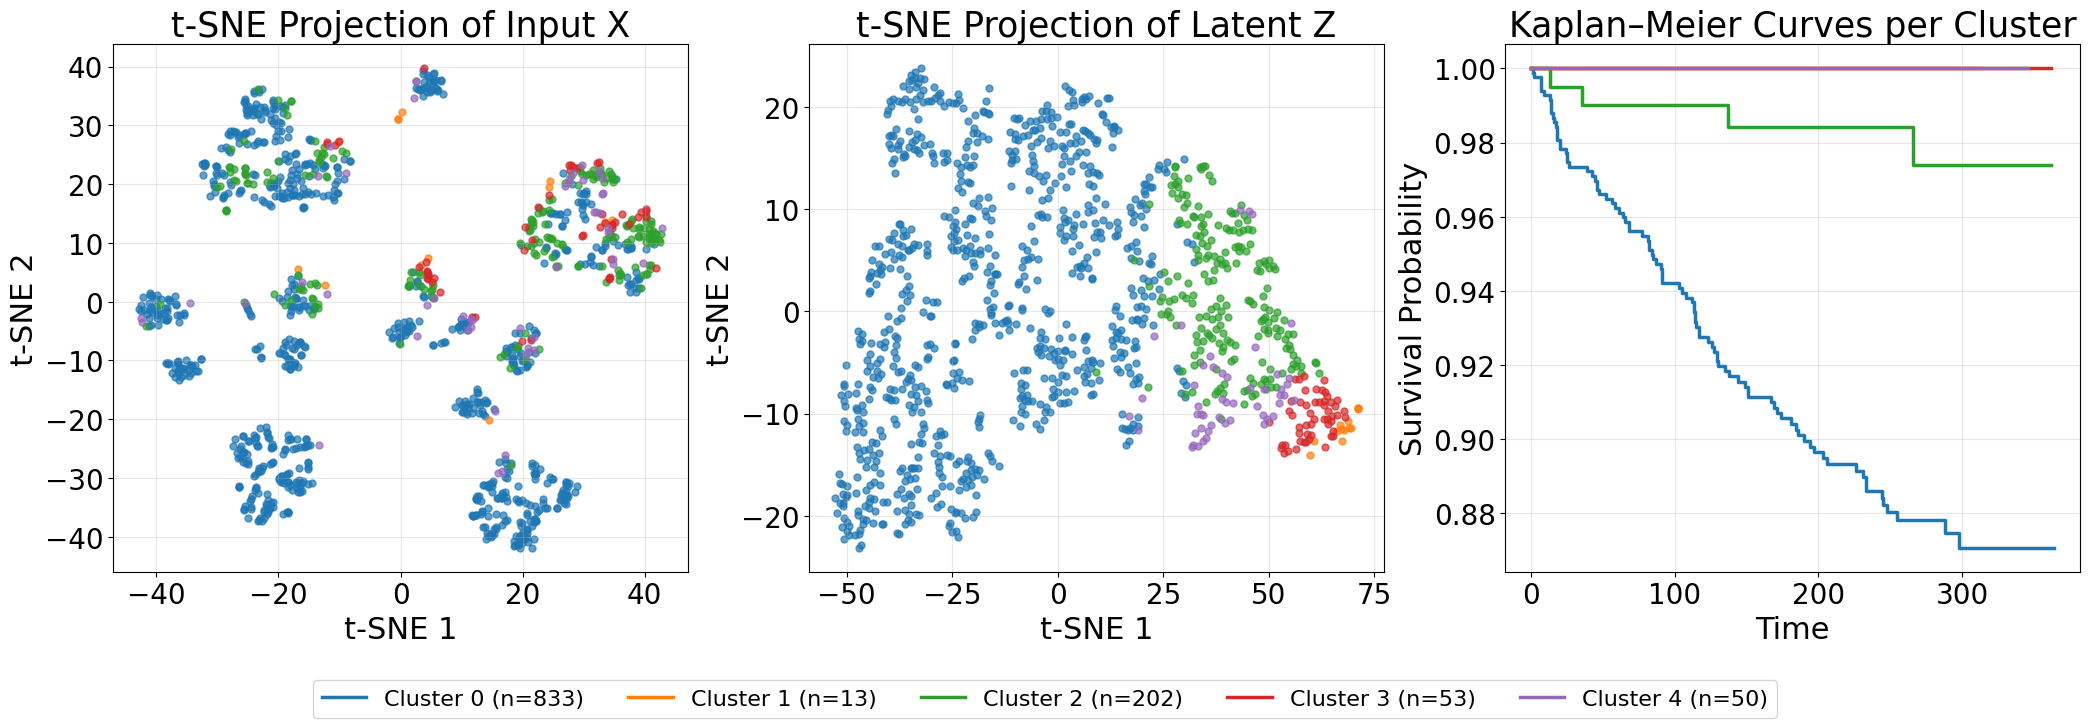

MODEL CONVERSE-Single ON DATASET BREAST
[INFO] Number of clusters: 8
[INFO] Number of non-empty clusters: 8
[INFO] Clusters with >5 samples: 8
[INFO] Log-rank test for cluster comparison (n>5)
Test statistic: 39.4529
p-value: 0.000002
*** Highly significant difference between clusters (p < 0.001) ***


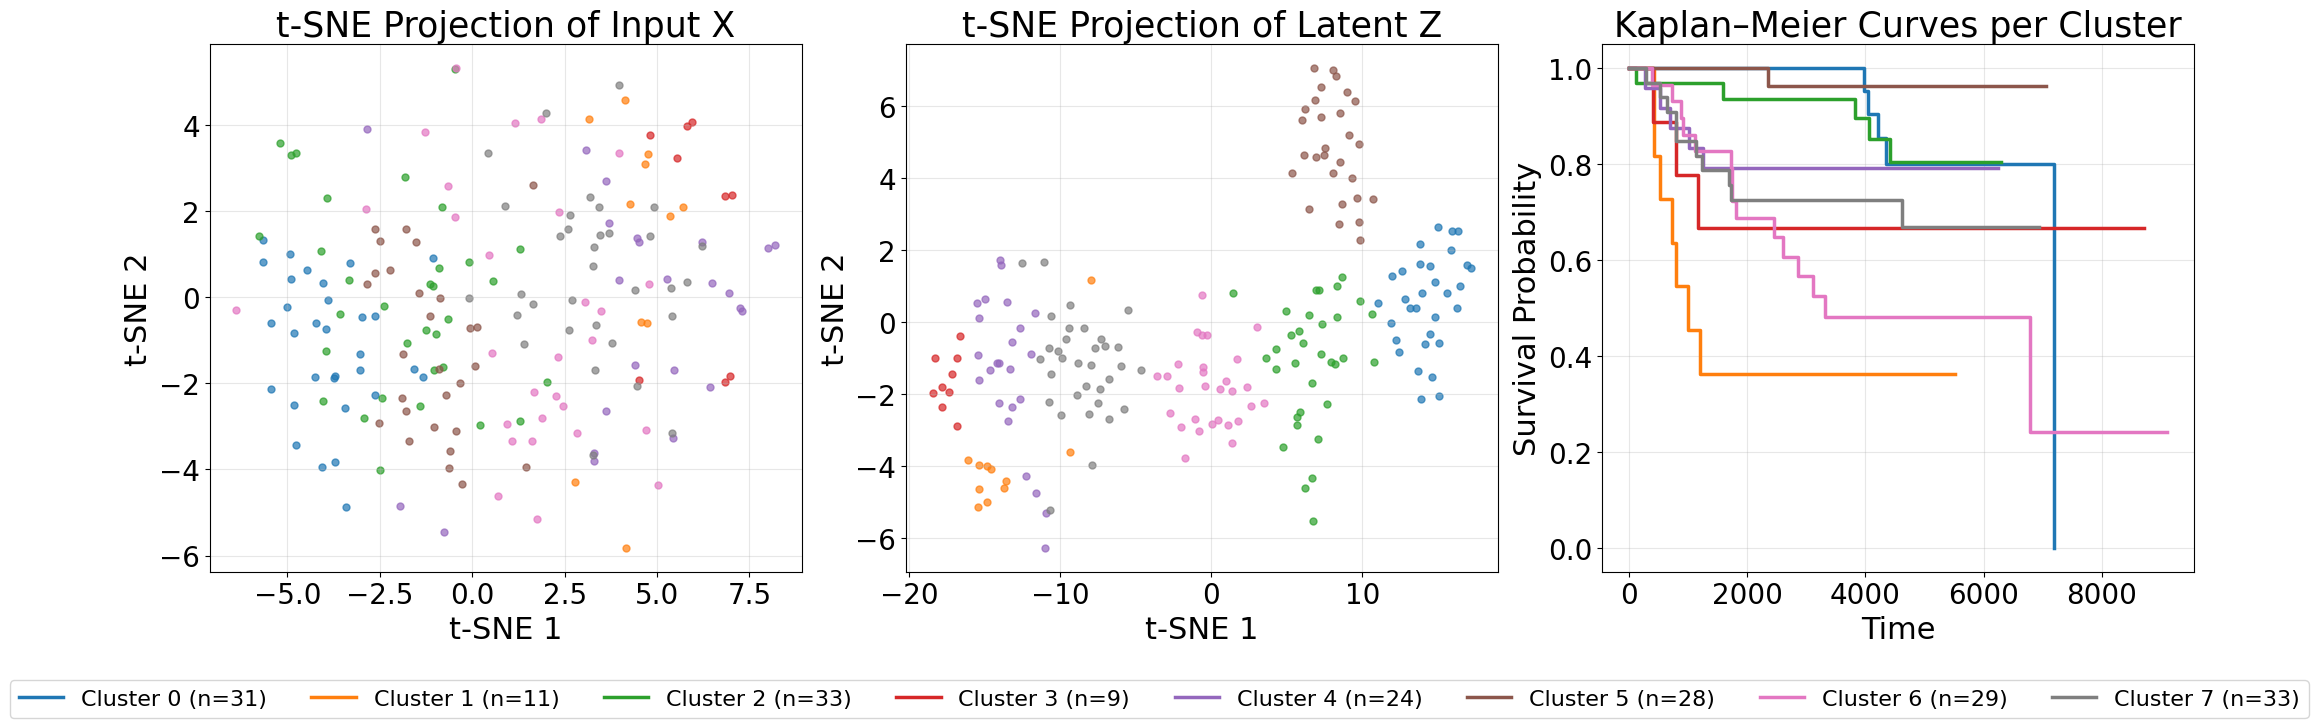

MODEL CONVERSE-Single ON DATASET GBSG
[INFO] Number of clusters: 4
[INFO] Number of non-empty clusters: 4
[INFO] Clusters with >5 samples: 4
[INFO] Log-rank test for cluster comparison (n>5)
Test statistic: 2.3125
p-value: 0.510127
*** No significant difference between clusters (p >= 0.05) ***


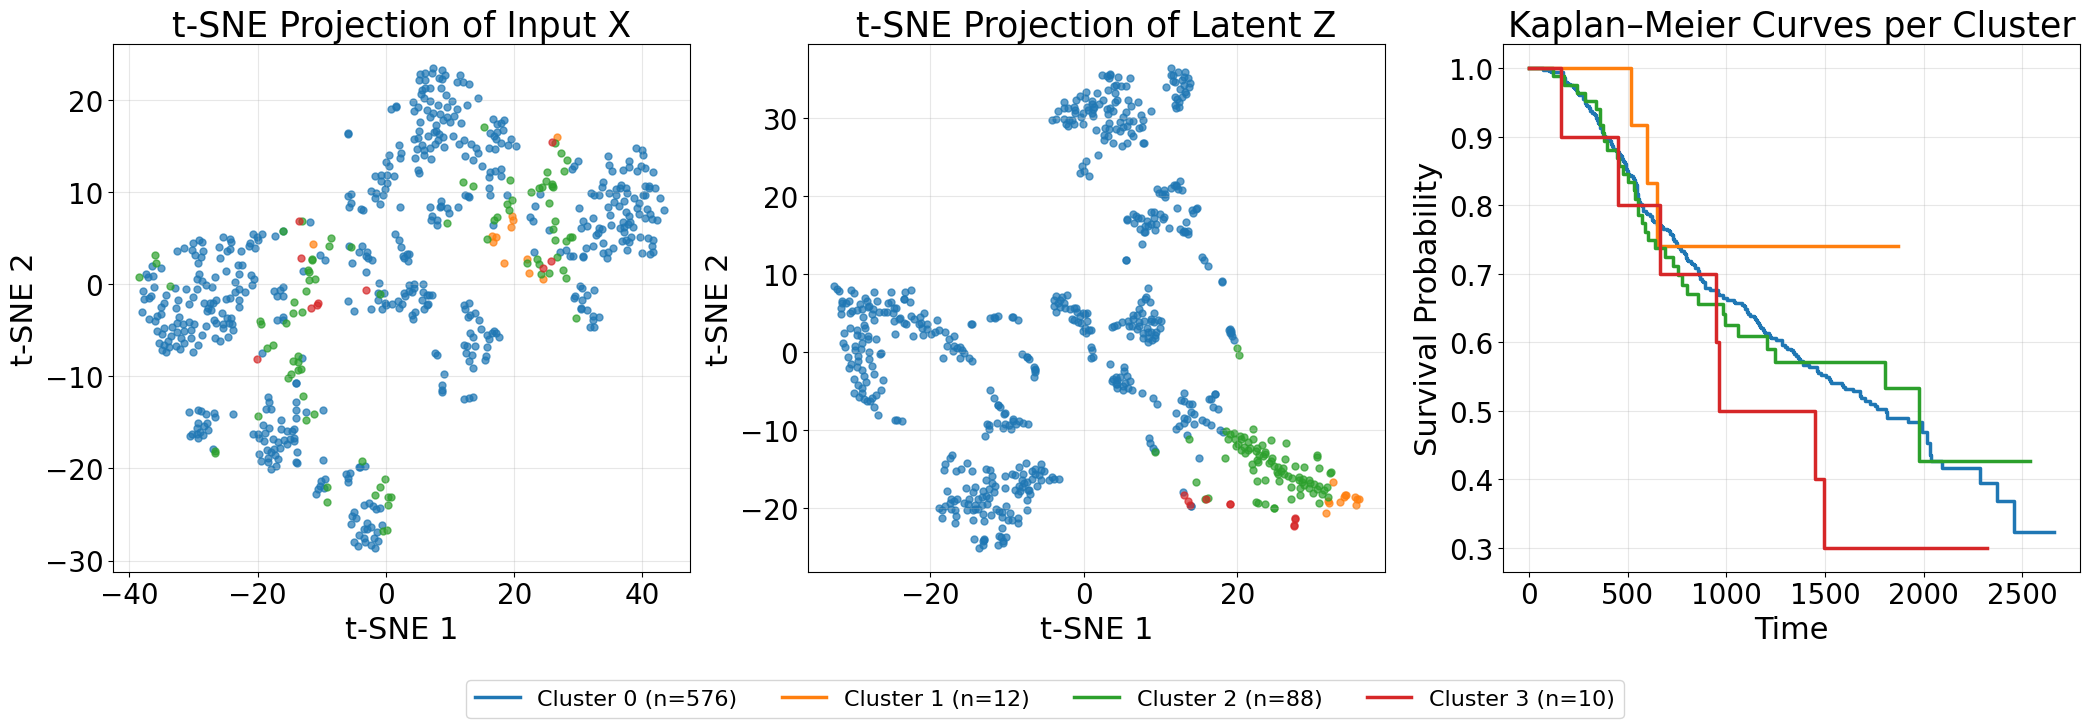

MODEL CONVERSE-Single ON DATASET METABRIC
[INFO] Number of clusters: 4
[INFO] Number of non-empty clusters: 4
[INFO] Clusters with >5 samples: 4
[INFO] Log-rank test for cluster comparison (n>5)
Test statistic: 28.4700
p-value: 0.000003
*** Highly significant difference between clusters (p < 0.001) ***


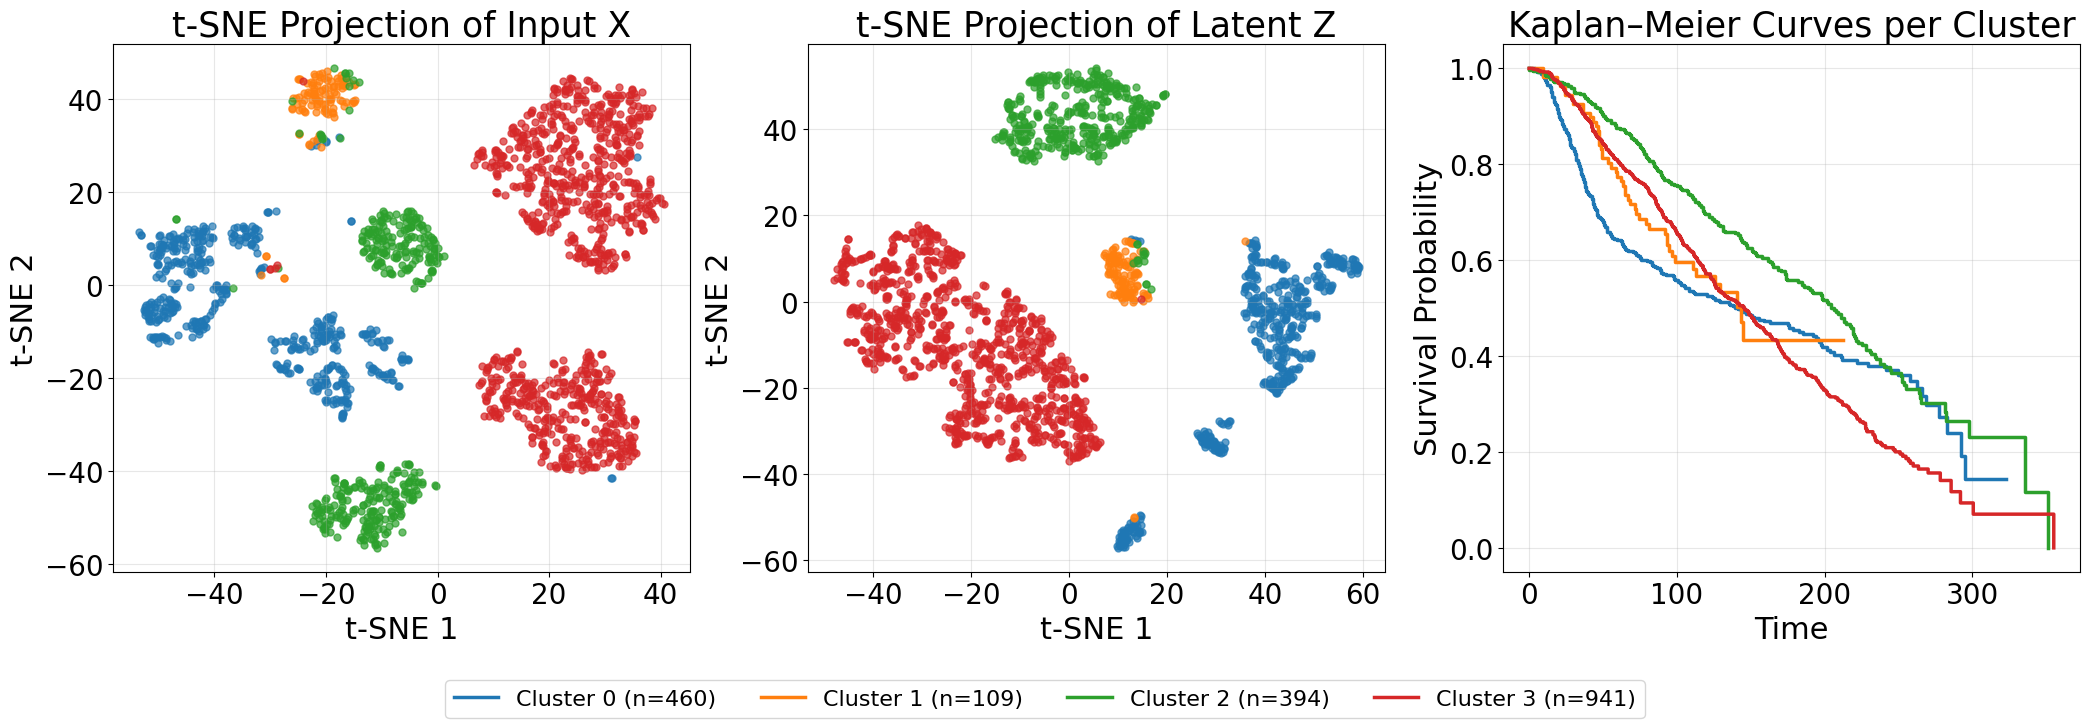

MODEL CONVERSE-Single ON DATASET PBC
[INFO] Number of clusters: 2
[INFO] Number of non-empty clusters: 2
[INFO] Clusters with >5 samples: 2
[INFO] Log-rank test for cluster comparison (n>5)
Test statistic: 104.0467
p-value: 0.000000
*** Highly significant difference between clusters (p < 0.001) ***


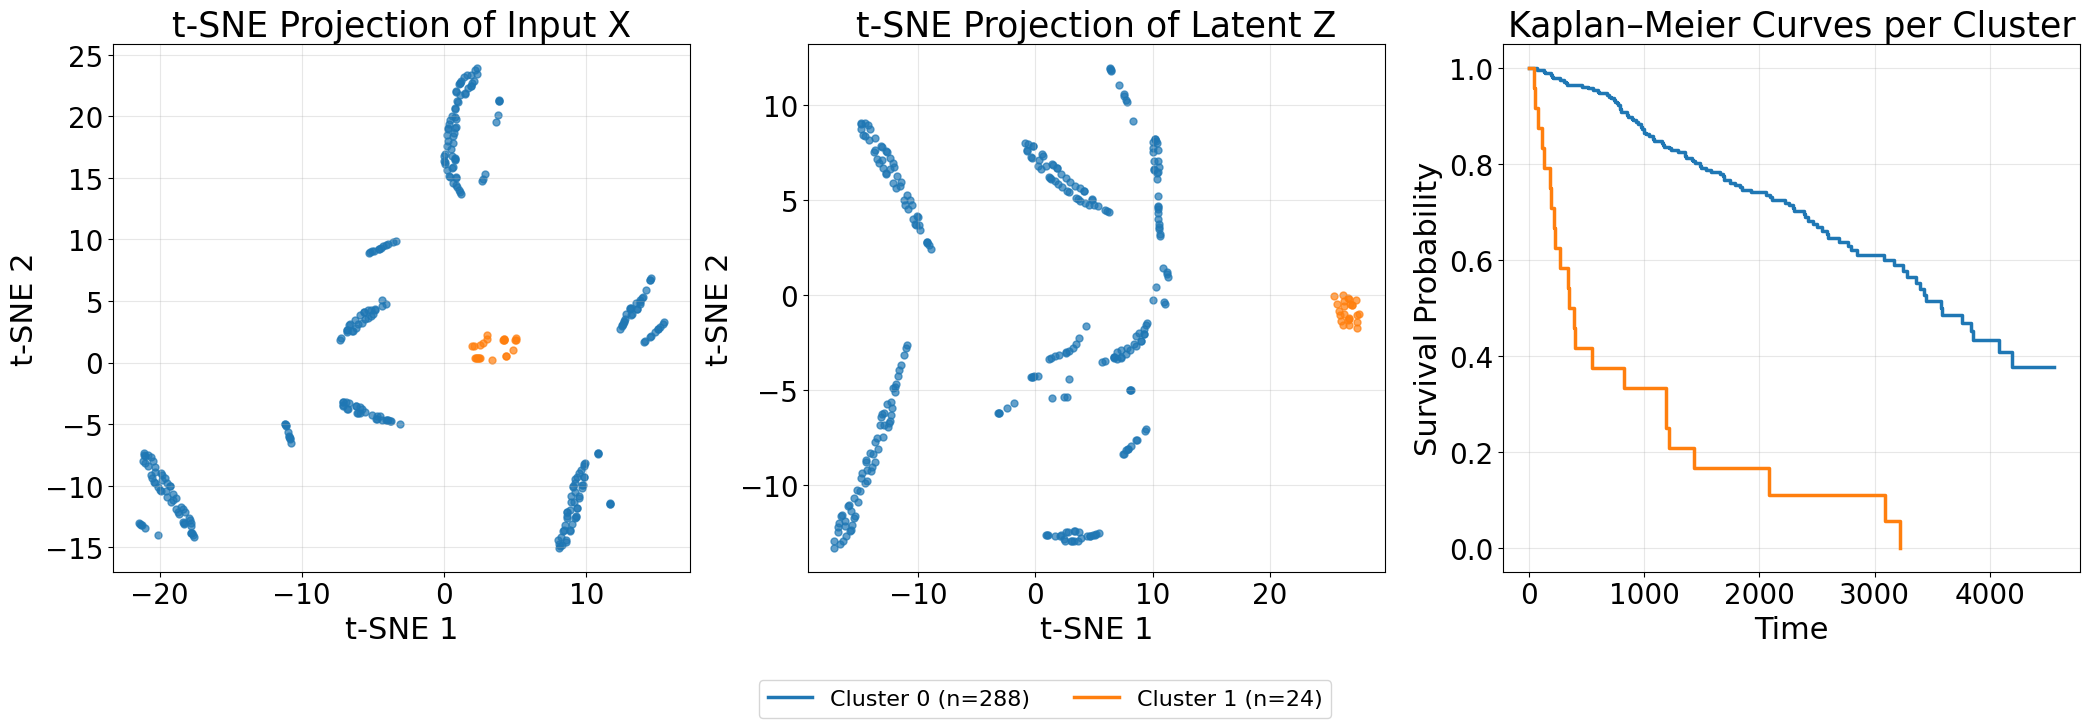

MODEL CONVERSE-Siamese ON DATASET TCGA-BRCA
[INFO] Number of clusters: 8
[INFO] Number of non-empty clusters: 8
[INFO] Clusters with >5 samples: 8
[INFO] Log-rank test for cluster comparison (n>5)
Test statistic: 94.2098
p-value: 0.000000
*** Highly significant difference between clusters (p < 0.001) ***


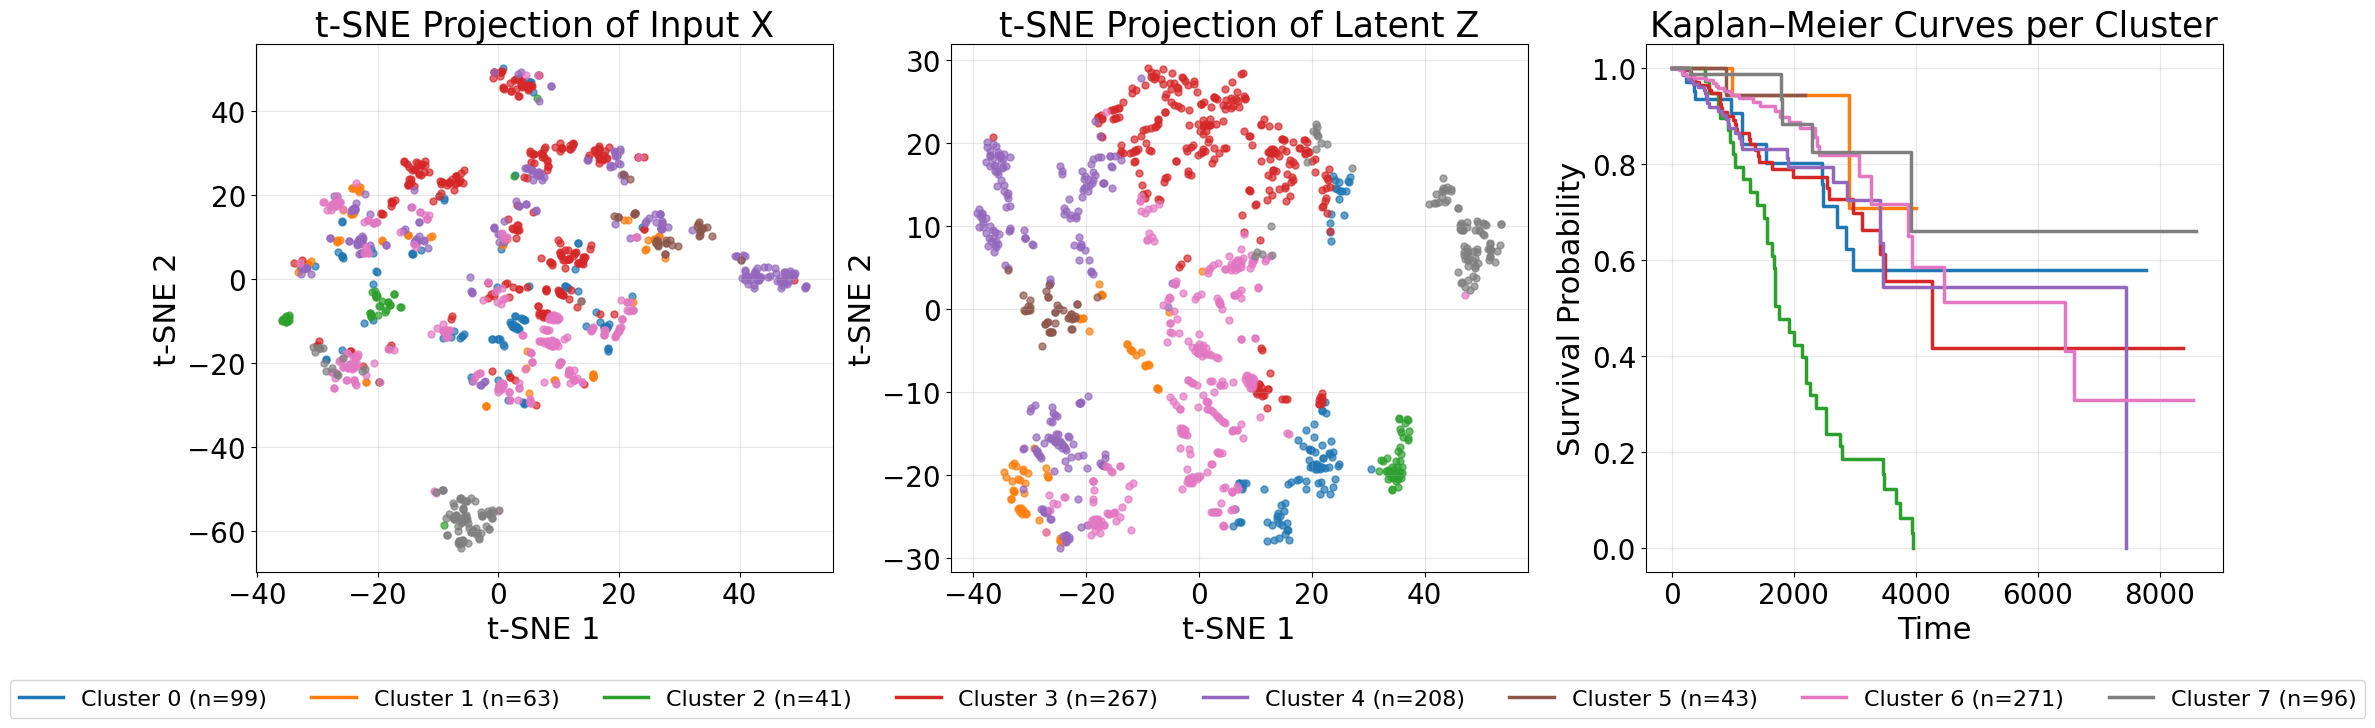

MODEL CONVERSE-Single ON DATASET VETERANS
[INFO] Number of clusters: 6
[INFO] Number of non-empty clusters: 6
[INFO] Clusters with >5 samples: 5
[INFO] Log-rank test for cluster comparison (n>5)
Test statistic: 9.6288
p-value: 0.047166
*** Significant difference between clusters (p < 0.05) ***


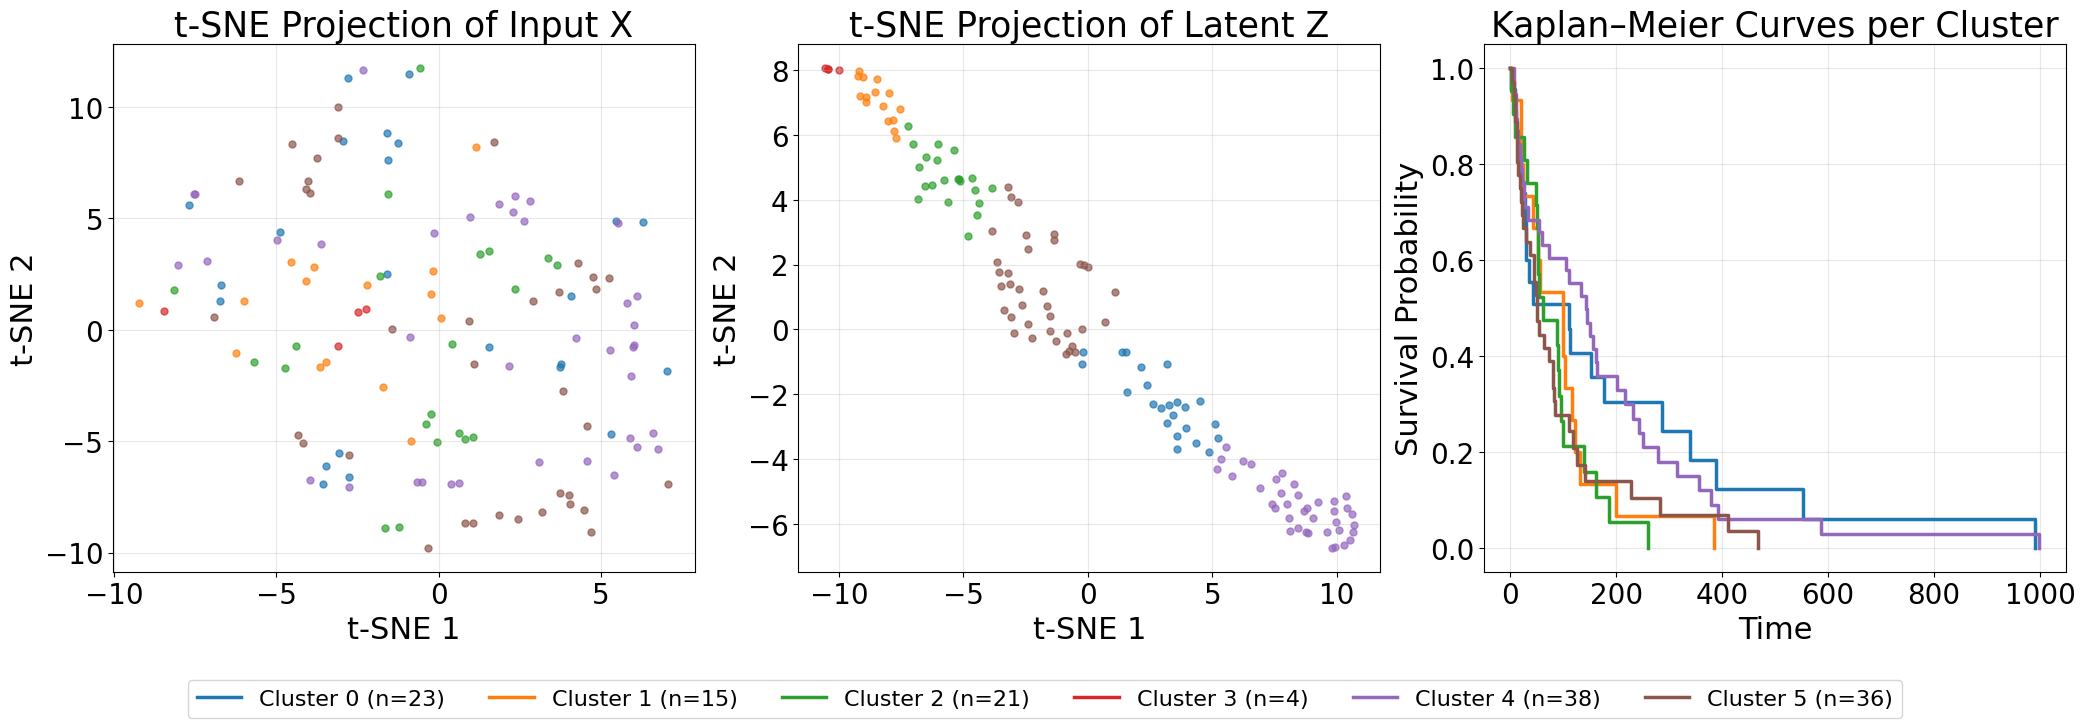

MODEL CONVERSE-Siamese ON DATASET WHAS
[INFO] Number of clusters: 5
[INFO] Number of non-empty clusters: 5
[INFO] Clusters with >5 samples: 4
[INFO] Log-rank test for cluster comparison (n>5)
Test statistic: 80.8847
p-value: 0.000000
*** Highly significant difference between clusters (p < 0.001) ***


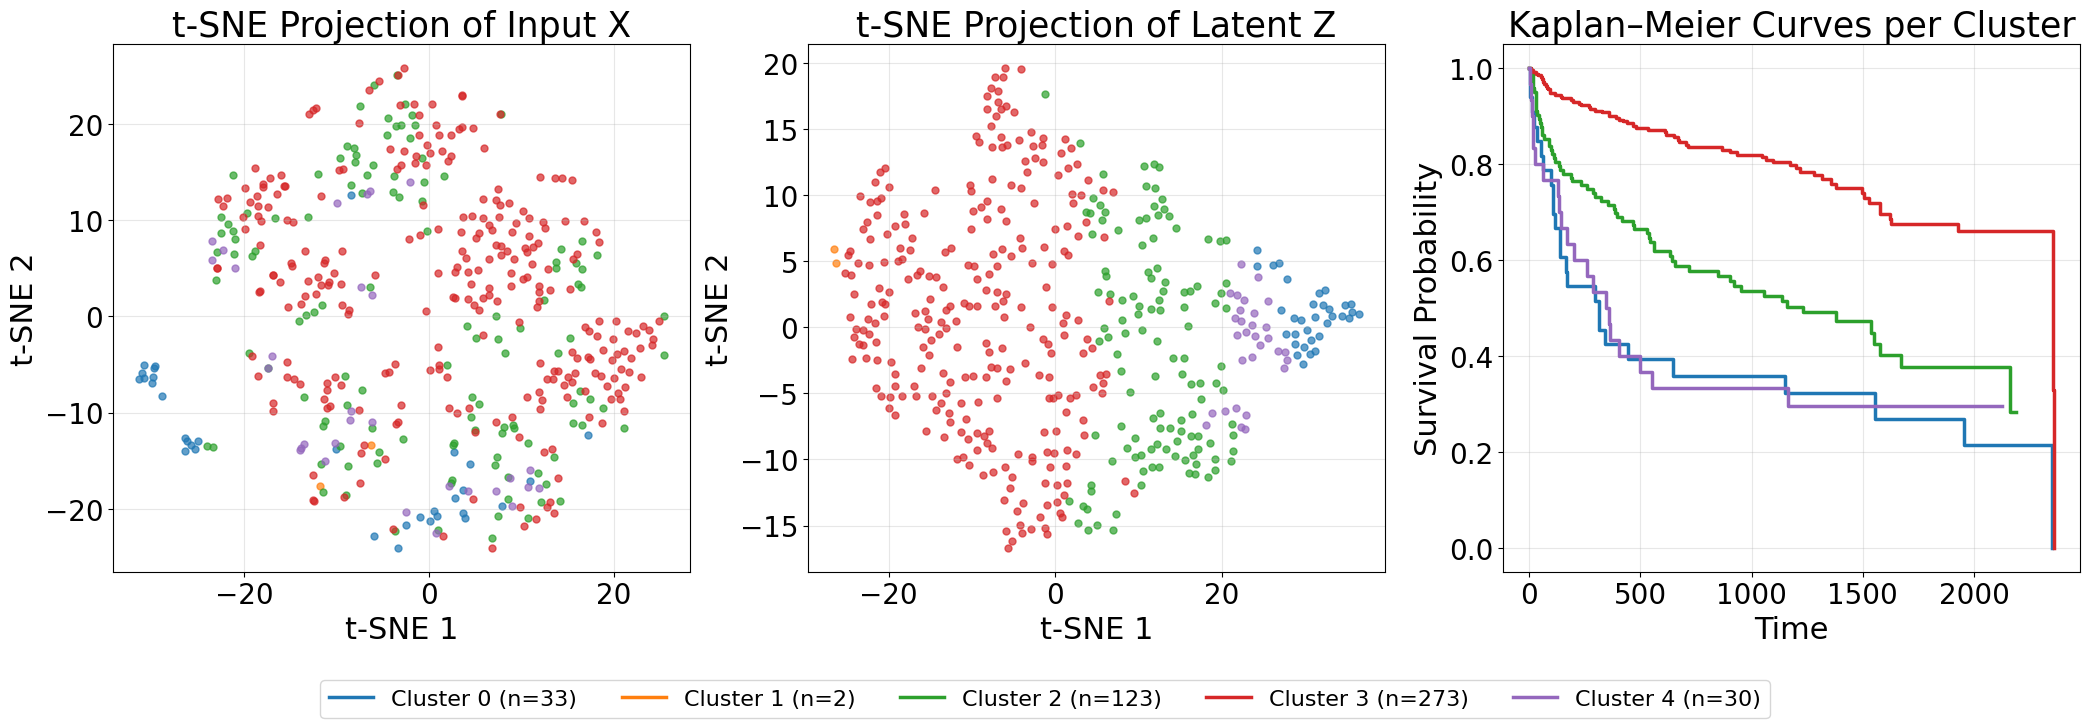

In [4]:
for DATASET, MODEL_NAME in best_model_per_dataset.items():
    # -------- Load model artifact --------
    MODEL_PATH = f"../{SAVED_FOLDER}/{DATASET}_{MODEL_NAME}_seed{SEED}.joblib"    
    artifact = joblib.load(MODEL_PATH)
    model = artifact["model"]
    prep = artifact["preprocessor"]

    # -------- Load test data --------
    # Load the saved test split that matches the trained model
    DATA_PATH = f"../survbase/datasets/{DATASET}.csv"
    df_test = pd.read_csv(DATA_PATH)

    print(f"="*80)
    print(f"MODEL {model_name_mapping[MODEL_NAME]} ON DATASET {dataset_name_mapping[DATASET]}")

    # -------- Preprocess --------
    X = prep.transform(df_test)
    T = df_test[TIME_COL].to_numpy()
    E = df_test[EVENT_COL].to_numpy().astype(int)

    # -------- Extract latent space & clusters --------
    Z = extract_latent(model, X)
    clusters = extract_clusters(model, X)

    print("[INFO] Number of clusters:", model.n_clusters)
    print("[INFO] Number of non-empty clusters:", len(np.unique(clusters)))

    # -------- Dimensionality reduction projections --------
    # Convert X to numpy if it's a DataFrame
    X_array = X.values if hasattr(X, 'values') else X

    # t-SNE on input X
    tsne_X = TSNE(n_components=2, random_state=SEED)
    X_tsne = tsne_X.fit_transform(X_array)

    # t-SNE on latent Z
    tsne = TSNE(n_components=2, random_state=SEED)
    Z_tsne = tsne.fit_transform(Z)

    # -------- Plot latent space dynamically based on top features --------
    fig = plt.figure(figsize=(21, 7))
    gs = GridSpec(1, 3, figure=fig, width_ratios=[1, 1, 1]) #, wspace=0.3)

    # Create axes: 2 columns for plots + 1 narrow column for colorbars
    axes = []
    cbar_axes = []
    row_axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]),  fig.add_subplot(gs[0, 2])]
    axes.append(row_axes)

    # Convert to numpy array for easier indexing
    axes = np.array(axes)

    # Get consistent colors for clusters
    unique_clusters = sorted(np.unique(clusters))
    n_clusters = model.n_clusters
    cluster_to_color = {cluster_id: plt.cm.tab10(cluster_id) for cluster_id in range(n_clusters)}

    # ========== COLUMN 0: Input X Projections ==========
    # t-SNE plot - input X colored by clusters
    for k in unique_clusters:
        idx = clusters == k
        color = cluster_to_color[k]
        axes[0, 0].scatter(X_tsne[idx, 0], X_tsne[idx, 1], 
                        marker='o', s=25, alpha=0.7, color=color, label=f'Cluster {k}')
    axes[0, 0].set_title("t-SNE Projection of Input X", fontsize=25)
    axes[0, 0].set_xlabel("t-SNE 1", fontsize=22)
    axes[0, 0].set_ylabel("t-SNE 2", fontsize=22)
    axes[0, 0].tick_params(axis='both', which='major', labelsize=20)
    axes[0, 0].grid(True, alpha=0.3)

    # ========== COLUMN 1: Colored by Clusters ==========
    # t-SNE plot - clusters
    for k in unique_clusters:
        idx = clusters == k
        color = cluster_to_color[k]
        axes[0, 1].scatter(Z_tsne[idx, 0], Z_tsne[idx, 1], 
                        marker='o', s=25, alpha=0.7, color=color, label=f'Cluster {k}')
    axes[0, 1].set_title("t-SNE Projection of Latent Z",  fontsize=25)
    axes[0, 1].set_xlabel("t-SNE 1",  fontsize=22)
    axes[0, 1].set_ylabel("t-SNE 2",  fontsize=22)
    axes[0, 1].tick_params(axis='both', which='major', labelsize=20)
    axes[0, 1].grid(True, alpha=0.3)

    # ========== COLUMN 2: Kaplan–Meier curves ==========
    kmf = KaplanMeierFitter()

    # Filter clusters with more than 5 samples
    unique_clusters_sorted = sorted(np.unique(clusters))
    cluster_counts = {k: np.sum(clusters == k) for k in unique_clusters_sorted}
    clusters_to_plot = [k for k in unique_clusters_sorted if cluster_counts[k] > 5]

    print(f"[INFO] Clusters with >5 samples: {len(clusters_to_plot)}")

    # Combined plot with all clusters (>5 samples)
    for k in clusters_to_plot:
        idx = clusters == k
        color = cluster_to_color[k]
        
        kmf.fit(
            durations=T[idx],
            event_observed=E[idx],
            label=f"Cluster {k} (n={np.sum(idx)})",
        )
        kmf.plot_survival_function(ax=axes[0, 2], ci_show=False, color=color, linewidth=2.5)

    # Calculate p-value for the plot
    mask = np.isin(clusters, clusters_to_plot)
    T_filtered = T[mask]
    E_filtered = E[mask]
    clusters_filtered = clusters[mask]

    result_plot = multivariate_logrank_test(
        event_durations=T_filtered,
        groups=clusters_filtered,
        event_observed=E_filtered
    )

    axes[0, 2].set_title(f"Kaplan–Meier Curves per Cluster",  fontsize=25)
    axes[0, 2].set_xlabel("Time",  fontsize=22)
    axes[0, 2].set_ylabel("Survival Probability",  fontsize=22)
    axes[0, 2].tick_params(axis='both', which='major', labelsize=20)
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].legend().set_visible(False)

    # 1. Manually create handles for ALL clusters
    # This ensures even the small clusters (n < 5) show up in the legend
    handles = []
    labels = []

    for k in unique_clusters:
        # Create a line object for the legend
        line = Line2D([0], [0], color=cluster_to_color[k], lw=2.5)
        handles.append(line)
        
        # Optional: calculate n for the label even if it wasn't plotted
        n_samples = np.sum(clusters == k)
        labels.append(f"Cluster {k} (n={n_samples})")

    # 2. Add the Legend using our manual handles
    fig.legend(handles, labels, 
            loc='lower center', 
            bbox_to_anchor=(0.5, -0.05), 
            fontsize=16, 
            ncol=8, 
            frameon=True)


    plt.tight_layout(rect=[0, 0.05, 1, 1])

    # Perform log-rank test (only for clusters with >5 samples)
    print("[INFO] Log-rank test for cluster comparison (n>5)")

    # Filter data to only include clusters with >5 samples
    mask = np.isin(clusters, clusters_to_plot)
    T_filtered = T[mask]
    E_filtered = E[mask]
    clusters_filtered = clusters[mask]

    result = multivariate_logrank_test(
        event_durations=T_filtered,
        groups=clusters_filtered,
        event_observed=E_filtered
    )

    print(f"Test statistic: {result.test_statistic:.4f}")
    print(f"p-value: {result.p_value:.6f}")

    if result.p_value < 0.001:
        print("*** Highly significant difference between clusters (p < 0.001) ***")
    elif result.p_value < 0.05:
        print("*** Significant difference between clusters (p < 0.05) ***")
    else:
        print("*** No significant difference between clusters (p >= 0.05) ***")

    print(f"="*80)

    plt.show()
    plt.close()


## Post-Processing

### Feature Mappings

In [5]:
# --- Helper Function for Cluster Signatures ---
def get_cluster_profiles(X, clusters, dataset_name):
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # Apply Mapping to Column Names here
    if dataset_name in dataset_name_mapping:
        X_scaled = X_scaled.rename(columns=feature_name_mapping[dataset_name])

    X_scaled['Cluster'] = clusters
    cluster_means = X_scaled.groupby('Cluster').mean()
    
    # Identify top 7 features based on absolute variance across clusters
    top_features = cluster_means.abs().mean().sort_values(ascending=False).head(7).index
    return cluster_means[top_features]

feature_name_mapping = {
    'aids':{
        'fac_sex': 'Sex',
        'num_age': 'Age',
        'fac_raceth': 'Race/Ethnicity',
        'num_cd4' : 'CD4 Count',
        "fac_karnof" : "Karnofsky Score",
        'fac_hemophil': 'Hemophilia',
        'num_priorzdv': 'Months of prior\n ZDV therapy',
        'fac_txgrp': 'Treatment Group',
        "fac_strat2": "Stratification\nGroup 2",
        'fac_tx': 'Treatment Type', #(usually 0 for control/monotherapy and 1 for the experimental/combination therapy).
        'fac_ivdrug': 'IV Drug Use History'
    },

    'breast_cancer': {
        'grade_poorly differentiated': 'Tumor grade: high',
        "X214919_s_at"   :  "EIF4EBP3: mTOR\ntranslation regulator",
        "X219588_s_at"   :  "NCAPG2:\nChromosome condensation",
        "X204768_s_at"   :  "FEN1: DNA replication",
        "X202240_at"     :  "PLK1: Mitotic kinase",
        "X218883_s_at"   :  "CENPU:\nCentromere/mitosis",
        "X211762_s_at"   :  "KPNA2:\nNuclear transport",
        "X204015_s_at"   :  "DUSP4:\nMAPK phosphatase",
        "X205034_at"     :  "CCNE2: G1/S cyclin",
        "X201663_s_at"   :  "SMC4:\nchromosome maintenance"
    },
    'gbsg': {
        'num_age': 'Age',
        'fac_tgrade': 'Tumour Grade',
        'fac_tgrade_II': 'Tumour Grade II',
        'fac_horTh': 'Hormone Therapy',
        'fac_horTh_no': 'No Hormone Therapy',
        'fac_horTh_yes': 'Hormone Therapy',
        'num_tsize': 'Tumour Size',
        'num_estrec': 'Estrogen Receptor',
        'num_progrec': 'Progesterone\nReceptor',
        'num_pnodes': 'Positive\nNodes',
        'fac_menostat': 'Menopausal Status',
        'fac_menostat_Pre': 'Pre Menopause',
        'fac_menostat_Post': 'Post Menopause',
    },
    'metabric': {
        'num_x0': 'EGFR Expression',
        'num_x1': 'Progesterone\nReceptor Status',
        'num_x2': 'HER2\nExpression',
        'num_x3': 'Ki-67 Expression',
        'fac_x4': 'Hormone Therapy',
        'fac_x5': 'Radiotherapy',
        'fac_x6': 'Chemotherapy',
        'fac_x7': 'Estrogen Receptor\nStatus',
        'num_x8': 'Age'
    },
    'whas': {
        'num_age': 'Age ',
        'num_hr': 'Heart Rate',
        'num_sysbp': 'Systolic\nBlood Pressure',
        'num_diasbp': 'Diastolic\nBlood Pressure',
        'num_bmi': 'Body Mass Index',
        'num_los': 'Length of Hospital Stay',
        'num_week': 'Week of Admission',
        'fac_gender': 'Sex',
        'fac_cvd': 'Cardiovascular Disease',
        'fac_afb': 'Atrial Fibrillation',
        'fac_sho': 'Cardiogenic Shock',
        'fac_chf': 'Congestive\nHeart Failure',
        'fac_av3': 'Complete Heart Block',
        'fac_miord': 'MI Order',
        'fac_mitype': 'MI Type',
        'fac_year': 'Year of Admission'
    },
    'tcga_brca': {
        'num_age': 'Age at\nDiagnosis',
        'fac_x0': 'Ethnicity:\nNot Hispanic/Latino',
        'fac_x1': 'Ethnicity:\nNot Reported',
        'fac_x2': 'Race:\nAsian',
        'fac_x3': 'Race:\nBlack/African American',
        'fac_x4': 'Race:\nNot Reported',
        'fac_x5': 'Race:\nWhite',
        'fac_x6': 'AJCC M\nStage:\nMX',
        'fac_x7': 'AJCC N Stage: N0 (i−)',
        'fac_x8': 'AJCC N Stage: N1',
        'fac_x9': 'AJCC N Stage: N1a',
        'fac_x10': 'AJCC N Stage: N2',
        'fac_x11': 'AJCC N Stage: N2a',
        'fac_x12': 'AJCC Stage: IA',
        'fac_x13': 'AJCC Stage: IIA',
        'fac_x14': 'AJCC Stage: IIB',
        'fac_x15': 'AJCC Stage: IIIA',
        'fac_x16': 'AJCC Stage: IIIC',
        'fac_x17': 'AJCC T Stage: T1c',
        'fac_x18': 'AJCC T Stage: T2',
        'fac_x19': 'AJCC T Stage: T3',
        'fac_x20': 'AJCC Edition: 5th',
        'fac_x21': 'AJCC Edition: 6th',
        'fac_x22': 'AJCC Edition: 7th',
        'fac_x23': 'ICD-10:C50.9',
        'fac_x24': 'Morphology:8500/3',
        'fac_x25': 'Morphology:8520/3',
        'fac_x26': 'Diagnosis:Infiltrating Duct\nCarcinoma',
        'fac_x27': 'Diagnosis:Lobular\nCarcinoma',
        'fac_x28': 'Prior\nMalignancy',
        'fac_x29': 'Synchronous\nMalignancy:\nNot Reported',
        'fac_x30': 'Treatment:\nNot Reported',
        'fac_x31': 'Treatment\nReceived',
        'fac_x32': 'Tumour Stage: I',
        'fac_x33': 'Tumour Stage: IA',
        'fac_x34': 'Tumour Stage: IIA',
        'fac_x35': 'Tumour Stage: IIB',
        'fac_x36': 'Tumour Stage: IIIA',
        'fac_x37': 'Tumour Stage:IIIC'
    },
    'veterans': {
        'Age_in_years': 'Age',
        'Karnofsky_score': 'Karnofsky Score',
        'Months_from_diagnosis': 'Months from Diagnosis',
        'Celltype_adeno': 'Cell Type:\nAdenocarcinoma',
        'Celltype_large': 'Cell Type: Large Cell',
        'Celltype_smallcell': 'Cell Type: Small Cell',
        'Celltype_squamous': 'Cell Type: Squamous',
        'Prior_therapy_yes': 'Prior Therapy: Yes',
        'Treatment_standard': 'Treatment: Standard',
        'Treatment_test': 'Treatment: Test'

    },
    'pbc': {
        'num_age': 'Age',
        'fac_sex_f': "Female",
        'fac_sex_m': "Male",
        'fac_trt': "Treatment\nassignment",
        'fac_hepato': "Hepatomegaly",
        'fac_spiders': "Spiders",
        'fac_ascites': "Ascites",
        'fac_edema': "Edema",
    }
}

### Merge Function

In [6]:
# ========================================================================
# CLUSTER MERGE DICTIONARY
# Define which model clusters to combine for each dataset
# Format: {dataset_name: {original_cluster_id: new_merged_cluster_id}}
# ========================================================================
CLUSTER_MERGE_MAP = {
    "aids": {0: 0, 1:3, 2:2, 3:3, 4:3},  
    "breast_cancer": {0: 0, 1:1, 2:0, 3:1, 4:1, 5:0, 6:1 , 7:1}, 
    "gbsg": {0: 0, 1: 1, 2: 0, 3:3},  
    "metabric": {0: 0, 1: 2, 2: 2, 3:3},
    "pbc": {0: 0, 1: 1},  # Keep as is
    "tcga_brca": {0:0, 1:0, 2:2, 3:0, 4:0, 5:0, 6:0, 7:7}, 
    "veterans": {0:0, 1: 1, 2:1, 3:1, 4:0, 5:1}, 
    "whas": {0: 0, 1:3, 2:2, 3:3, 4:0}  
}
def merge_clusters(DATASET):
    MODEL_NAME = best_model_per_dataset[DATASET]
    MODEL_PATH = f"../{SAVED_FOLDER}/{DATASET}_{MODEL_NAME}_seed{SEED}.joblib"   

    artifact = joblib.load(MODEL_PATH)
    model = artifact["model"]
    prep = artifact["preprocessor"]
        
    df_test = pd.read_csv(f"../survbase/datasets/{DATASET}.csv")
    X = prep.transform(df_test)
    T = df_test[TIME_COL].to_numpy()
    E = df_test[EVENT_COL].to_numpy().astype(int)

    # -------- Extract Latent Space & Original Clusters --------
    Z = extract_latent(model, X)
    original_clusters = extract_clusters(model, X)
    unique_original = sorted(np.unique(original_clusters))
    
    # -------- Dimensionality Reduction for Plotting --------
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=min(30, len(Z)-1))
    Z_tsne = tsne.fit_transform(Z)

    # -------- Apply Merge Mapping --------
    merge_map = CLUSTER_MERGE_MAP[DATASET]
    merged_clusters = np.array([merge_map.get(c, c) for c in original_clusters])
    unique_merged = sorted(np.unique(merged_clusters))
    print(f"[INFO] Merge mapping: {merge_map}")
    print(f"[INFO] Merged clusters: {unique_merged}")

    # Color mappings
    original_colors = {cid: plt.cm.tab10(i % 10) for i, cid in enumerate(unique_original)}
    if DATASET == "aids":
        merged_colors = {0: original_colors[0], 2: original_colors[2], 3: original_colors[3]} #aids
    elif DATASET == "breast_cancer":
        merged_colors = {0: original_colors[0], 1: original_colors[1], 6: original_colors[6]} #breast
    elif DATASET == "gbsg":
        merged_colors = {0: original_colors[0], 1: original_colors[1], 3: original_colors[3]} #gbsg
    elif DATASET == "metabric":
        merged_colors = {0: original_colors[0], 1: original_colors[1], 2:original_colors[2], 3: original_colors[3]} #metabric
    elif DATASET == "tcga_brca":
        merged_colors = {0: original_colors[0], 7: original_colors[7], 2: original_colors[2]} #tcga
    elif DATASET == "veterans":
        merged_colors = {0: original_colors[0], 1: original_colors[1], 2: original_colors[2], 3: original_colors[3], 4: original_colors[4], 5: original_colors[5]} #veterans
    elif DATASET == "whas":             
        merged_colors = {0: original_colors[0], 1: original_colors[1], 2: original_colors[2], 3: original_colors[3]}   #whas
    else:
        merged_colors = original_colors #pbc

    # ====================================================================
    # SINGLE FIGURE: 2x2 - Original | Merged | KM Curves | Signatures
    # ====================================================================
    fig = plt.figure(figsize=(14, 14))
    gs = GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.3)

    # --- Top Left: Original Model Clusters ---
    ax_orig = fig.add_subplot(gs[0, 0])
    for cluster_id in unique_original:
        mask = original_clusters == cluster_id
        ax_orig.scatter(Z_tsne[mask, 0], Z_tsne[mask, 1], 
                        c=[original_colors[cluster_id]], 
                        label=f'C{cluster_id} (n={np.sum(mask)})',
                        alpha=0.7, s=25, marker='o')
    ax_orig.set_title(f"Original Model Clusters", 
                        fontweight='bold', fontsize=25)
    ax_orig.set_xlabel("t-SNE 1", fontsize=22)
    ax_orig.set_ylabel("t-SNE 2", fontsize=22)
    ax_orig.legend(loc='upper right', fontsize=16)
    ax_orig.tick_params(axis='both', which='major', labelsize=20)
    ax_orig.grid(True, alpha=0.3)

    # --- Top Right: Merged Clusters ---
    ax_merged = fig.add_subplot(gs[0, 1])
    for cluster_id in unique_merged:
        mask = merged_clusters == cluster_id
        ax_merged.scatter(Z_tsne[mask, 0], Z_tsne[mask, 1], 
                        c=[merged_colors[cluster_id]], 
                        label=f'M{cluster_id} (n={np.sum(mask)})',
                        alpha=0.7, s=25, marker='o')
    ax_merged.set_title(f"Merged Clusters ({len(unique_merged)} groups)", 
                        fontweight='bold', fontsize=25)
    ax_merged.set_xlabel("t-SNE 1", fontsize=22)
    ax_merged.set_ylabel("t-SNE 2", fontsize=22)
    ax_merged.legend(loc='upper right', fontsize=16)
    ax_merged.tick_params(axis='both', which='major', labelsize=20)
    ax_merged.grid(True, alpha=0.3)

    # --- Bottom Left: Merged Clusters Kaplan-Meier Curves ---
    ax_km = fig.add_subplot(gs[1, 0])
    kmf = KaplanMeierFitter()

    for k in unique_merged:
        idx = merged_clusters == k
        if np.sum(idx) > 5:  # Only plot clusters with >5 samples
            kmf.fit(T[idx], E[idx], label=f"M{k} (n={np.sum(idx)})")
            kmf.plot_survival_function(ax=ax_km, ci_show=False, 
                                        color=merged_colors[k], 
                                        linewidth=2.5)

    # Log-rank test
    lr_res = multivariate_logrank_test(T, merged_clusters, E)
    ax_km.set_title(f"Merged Groups Survival", 
                    fontweight='bold', fontsize=25)
    ax_km.set_xlabel("Time (days)", fontsize=22)
    ax_km.set_ylabel("Survival Probability", fontsize=22)
    ax_km.legend(loc='best', fontsize=16)
    ax_km.grid(True, alpha=0.3)
    ax_km.tick_params(axis='both', which='major', labelsize=20)

    # --- Bottom Right: Merged Cluster Clinical Signatures ---
    ax_sig = fig.add_subplot(gs[1, 1])
    merged_profile_data = get_cluster_profiles(X, merged_clusters, DATASET)

    merged_profile_data.T.plot(kind='barh', ax=ax_sig, 
                                color=[merged_colors[c] for c in unique_merged], 
                                alpha=0.8)
    ax_sig.axvline(0, color='black', linestyle='--', alpha=0.5)
    ax_sig.set_title(f"Merged Groups Clinical Signatures", 
                            fontweight='bold', fontsize=25, x=0.65)
    ax_sig.set_xlabel("Standard Deviations from Mean", fontsize=22)
    ax_sig.legend(loc='best', fontsize=16)
    ax_sig.tick_params(axis='both', which='major', labelsize=20)
    ax_sig.yaxis.tick_right()  # Move y-axis labels to the right
    ax_sig.yaxis.set_label_position("right")  # Move y-axis label to the right

    # Print log-rank test results
    print(f"[INFO] Merged Clusters Log-Rank Test Results:")
    print(f"Test statistic: {lr_res.test_statistic:.4f}")
    print(f"p-value: {lr_res.p_value:.6f}")
    if lr_res.p_value < 0.001:
        print("*** Highly significant (p < 0.001) ***")
    elif lr_res.p_value < 0.05:
        print("*** Significant (p < 0.05) ***")
    else:
        print("*** Not significant (p >= 0.05) ***")

    plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space for labels to overflow on the right
    plt.show()


### AIDS

[INFO] Merge mapping: {0: 0, 1: 3, 2: 2, 3: 3, 4: 3}
[INFO] Merged clusters: [np.int64(0), np.int64(2), np.int64(3)]
[INFO] Merged Clusters Log-Rank Test Results:
Test statistic: 27.6724
p-value: 0.000001
*** Highly significant (p < 0.001) ***


/tmp/ipykernel_102631/1976485285.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space for labels to overflow on the right


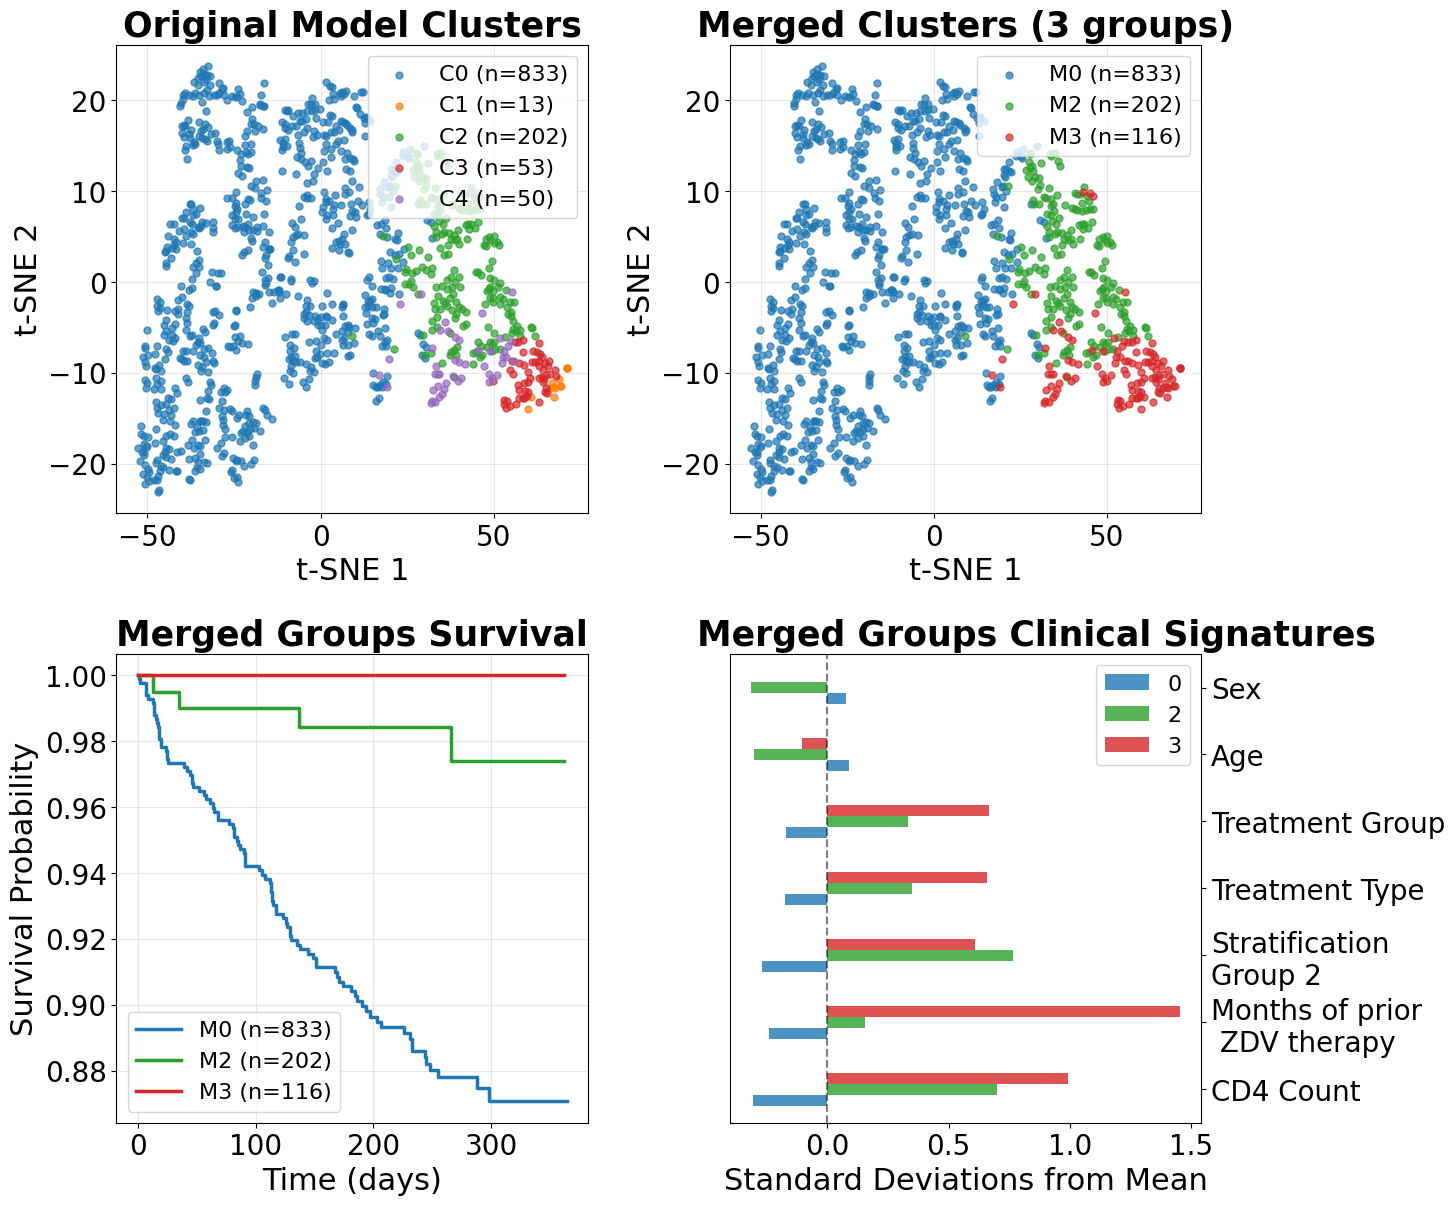

In [7]:
merge_clusters("aids")

### BREAST

[INFO] Merge mapping: {0: 0, 1: 1, 2: 0, 3: 1, 4: 1, 5: 0, 6: 1, 7: 1}
[INFO] Merged clusters: [np.int64(0), np.int64(1)]
[INFO] Merged Clusters Log-Rank Test Results:
Test statistic: 18.4463
p-value: 0.000017
*** Highly significant (p < 0.001) ***


/tmp/ipykernel_102631/1976485285.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space for labels to overflow on the right


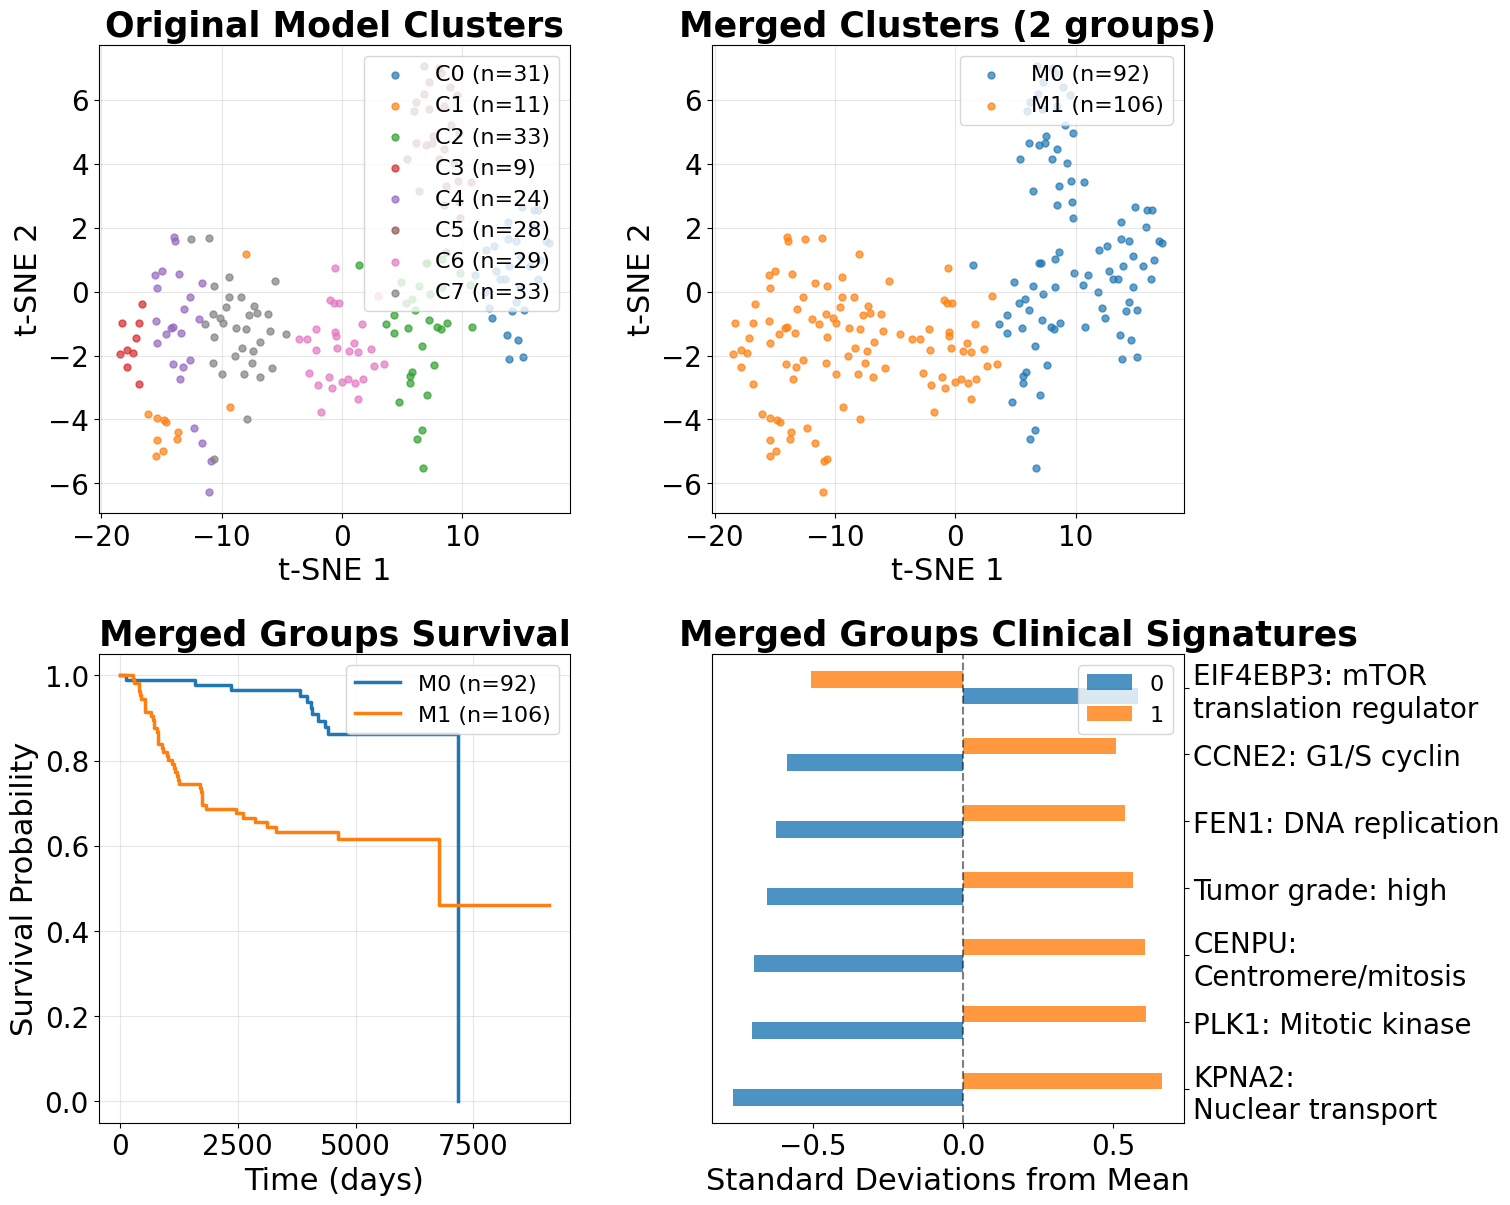

In [8]:
merge_clusters("breast_cancer")

### GBSG

[INFO] Original model clusters count: 4
[INFO] K-means identified 3 clusters.
[INFO] K-Means Clusters Log-Rank Test Results:
Test statistic: 10.1422
p-value: 0.006275
*** Significant (p < 0.05) ***


/tmp/ipykernel_102631/3202359216.py:116: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space for labels to overflow on the right


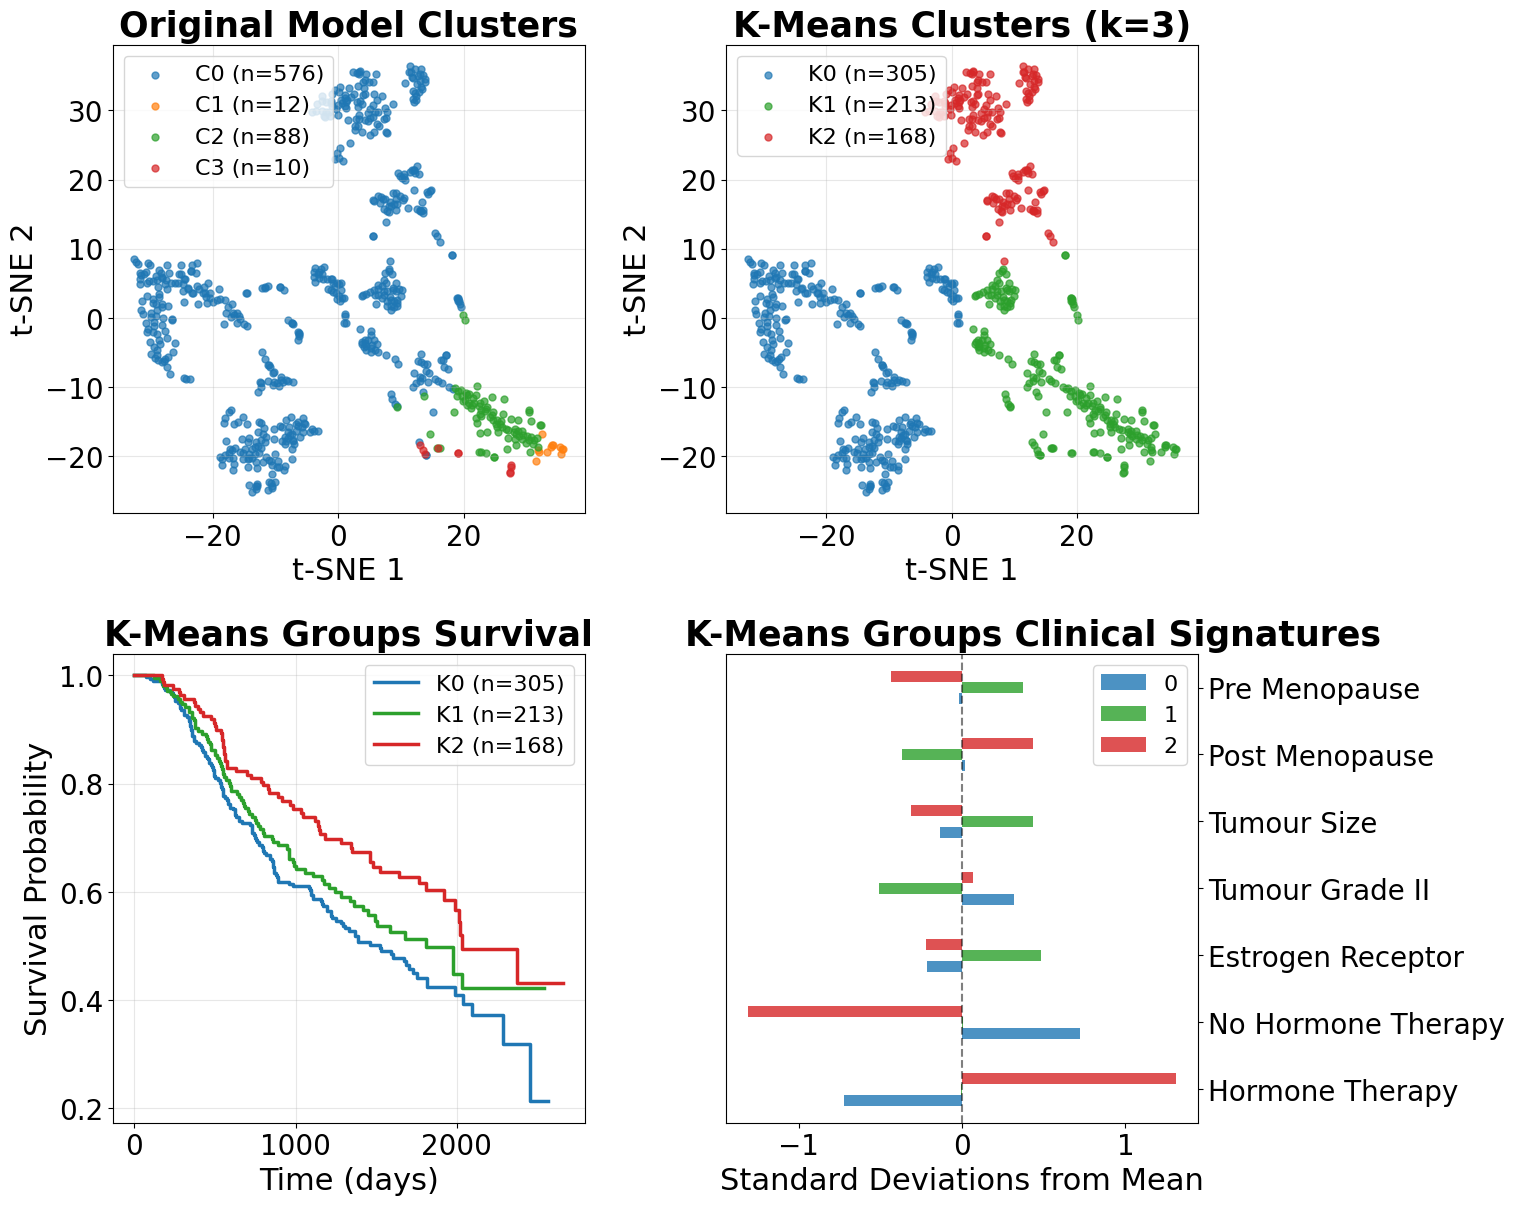

In [9]:
N_CLUSTERS = 3  # Set how many clusters you want K-means to find
DATASET = "gbsg"
MODEL_NAME = best_model_per_dataset[DATASET]
MODEL_PATH = f"../{SAVED_FOLDER}/{DATASET}_{MODEL_NAME}_seed{SEED}.joblib"   

artifact = joblib.load(MODEL_PATH)
model = artifact["model"]
prep = artifact["preprocessor"]

df_test = pd.read_csv(f"../survbase/datasets/{DATASET}.csv")
X = prep.transform(df_test)
T = df_test[TIME_COL].to_numpy()
E = df_test[EVENT_COL].to_numpy().astype(int)

# -------- Extract Latent Space & Original Clusters --------
Z = extract_latent(model, X)
original_clusters = extract_clusters(model, X)
unique_original = sorted(np.unique(original_clusters))

# -------- Dimensionality Reduction for Plotting --------
tsne = TSNE(n_components=2, random_state=SEED, perplexity=min(30, len(Z)-1))
Z_tsne = tsne.fit_transform(Z)

# -------- APPLY K-MEANS --------
# We apply KMeans on the latent space (Z) to find structural groups
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=SEED, n_init=10)
kmeans_clusters = kmeans.fit_predict(Z_tsne)
unique_kmeans = sorted(np.unique(kmeans_clusters))

print(f"[INFO] Original model clusters count: {len(unique_original)}")
print(f"[INFO] K-means identified {N_CLUSTERS} clusters.")

# Color mappings
original_colors = {cid: plt.cm.tab10(i % 10) for i, cid in enumerate(unique_original)}
kmeans_colors = {0: original_colors[0], 1: original_colors[2], 2: original_colors[3]} # Adjust based on your dataset's original clusters

# ====================================================================
# SINGLE FIGURE: 2x2 - Original | K-Means | KM Curves | Signatures
# ====================================================================
fig = plt.figure(figsize=(14, 14))
gs = GridSpec(2, 2, figure=fig, wspace=0.3, hspace=0.3)

# --- Top Left: Original Model Clusters ---
ax_orig = fig.add_subplot(gs[0, 0])
for cluster_id in unique_original:
    mask = original_clusters == cluster_id
    ax_orig.scatter(Z_tsne[mask, 0], Z_tsne[mask, 1], 
                    c=[original_colors[cluster_id]], 
                    label=f'C{cluster_id} (n={np.sum(mask)})',
                    alpha=0.7, s=25, marker='o')
ax_orig.set_title("Original Model Clusters", fontweight='bold', fontsize=25)
ax_orig.set_xlabel("t-SNE 1", fontsize=22)
ax_orig.set_ylabel("t-SNE 2", fontsize=22)
ax_orig.legend(loc='upper left', fontsize=16)
ax_orig.tick_params(axis='both', which='major', labelsize=20)
ax_orig.grid(True, alpha=0.3)

# --- Top Right: K-Means Clusters ---
ax_km_clusters = fig.add_subplot(gs[0, 1])
for cluster_id in unique_kmeans:
    mask = kmeans_clusters == cluster_id
    ax_km_clusters.scatter(Z_tsne[mask, 0], Z_tsne[mask, 1], 
                            c=[kmeans_colors[cluster_id]], 
                            label=f'K{cluster_id} (n={np.sum(mask)})',
                            alpha=0.7, s=25, marker='o')
ax_km_clusters.set_title(f"K-Means Clusters (k={N_CLUSTERS})", fontweight='bold', fontsize=25)
ax_km_clusters.set_xlabel("t-SNE 1", fontsize=22)
ax_km_clusters.set_ylabel("t-SNE 2", fontsize=22)
ax_km_clusters.legend(loc='upper left', fontsize=16)
ax_km_clusters.tick_params(axis='both', which='major', labelsize=20)
ax_km_clusters.grid(True, alpha=0.3)

# --- Bottom Left: K-Means Kaplan-Meier Curves ---
ax_km_plot = fig.add_subplot(gs[1, 0])
kmf = KaplanMeierFitter()

for k in unique_kmeans:
    idx = kmeans_clusters == k
    if np.sum(idx) > 0:
        kmf.fit(T[idx], E[idx], label=f"K{k} (n={np.sum(idx)})")
        kmf.plot_survival_function(ax=ax_km_plot, ci_show=False, color=kmeans_colors[k], linewidth=2.5)

# Log-rank test
lr_res = multivariate_logrank_test(T, kmeans_clusters, E)
ax_km_plot.set_title(f"K-Means Groups Survival", fontweight='bold', fontsize=25)
ax_km_plot.set_xlabel("Time (days)", fontsize=22)
ax_km_plot.set_ylabel("Survival Probability", fontsize=22)
ax_km_plot.legend(loc='best', fontsize=16)
ax_km_plot.tick_params(axis='both', which='major', labelsize=20)
ax_km_plot.grid(True, alpha=0.3)

# --- Bottom Right: K-Means Clinical Signatures ---
ax_sig = fig.add_subplot(gs[1, 1])
km_profile_data = get_cluster_profiles(X, kmeans_clusters, DATASET)

km_profile_data.T.plot(kind='barh', ax=ax_sig, color=[kmeans_colors[c] for c in unique_kmeans], alpha=0.8)
ax_sig.axvline(0, color='black', linestyle='--', alpha=0.5)
ax_sig.set_title(f"K-Means Groups Clinical Signatures", fontweight='bold', fontsize=25, x=0.65)
ax_sig.set_xlabel("Standard Deviations from Mean", fontsize=22)
ax_sig.legend(loc='best', fontsize=16)
ax_sig.tick_params(axis='both', which='major', labelsize=20)
ax_sig.yaxis.tick_right()  # Move y-axis labels to the right
ax_sig.yaxis.set_label_position("right")  # Move y-axis label to the right

# Print log-rank test results
print(f"[INFO] K-Means Clusters Log-Rank Test Results:")
print(f"Test statistic: {lr_res.test_statistic:.4f}")
print(f"p-value: {lr_res.p_value:.6f}")
if lr_res.p_value < 0.001:
    print("*** Highly significant (p < 0.001) ***")
elif lr_res.p_value < 0.05:
    print("*** Significant (p < 0.05) ***")
else:
    print("*** Not significant (p >= 0.05) ***")

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space for labels to overflow on the right
plt.show()

### METABRIC

[INFO] Merge mapping: {0: 0, 1: 2, 2: 2, 3: 3}
[INFO] Merged clusters: [np.int64(0), np.int64(2), np.int64(3)]
[INFO] Merged Clusters Log-Rank Test Results:
Test statistic: 23.8334
p-value: 0.000007
*** Highly significant (p < 0.001) ***


/tmp/ipykernel_102631/1976485285.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space for labels to overflow on the right


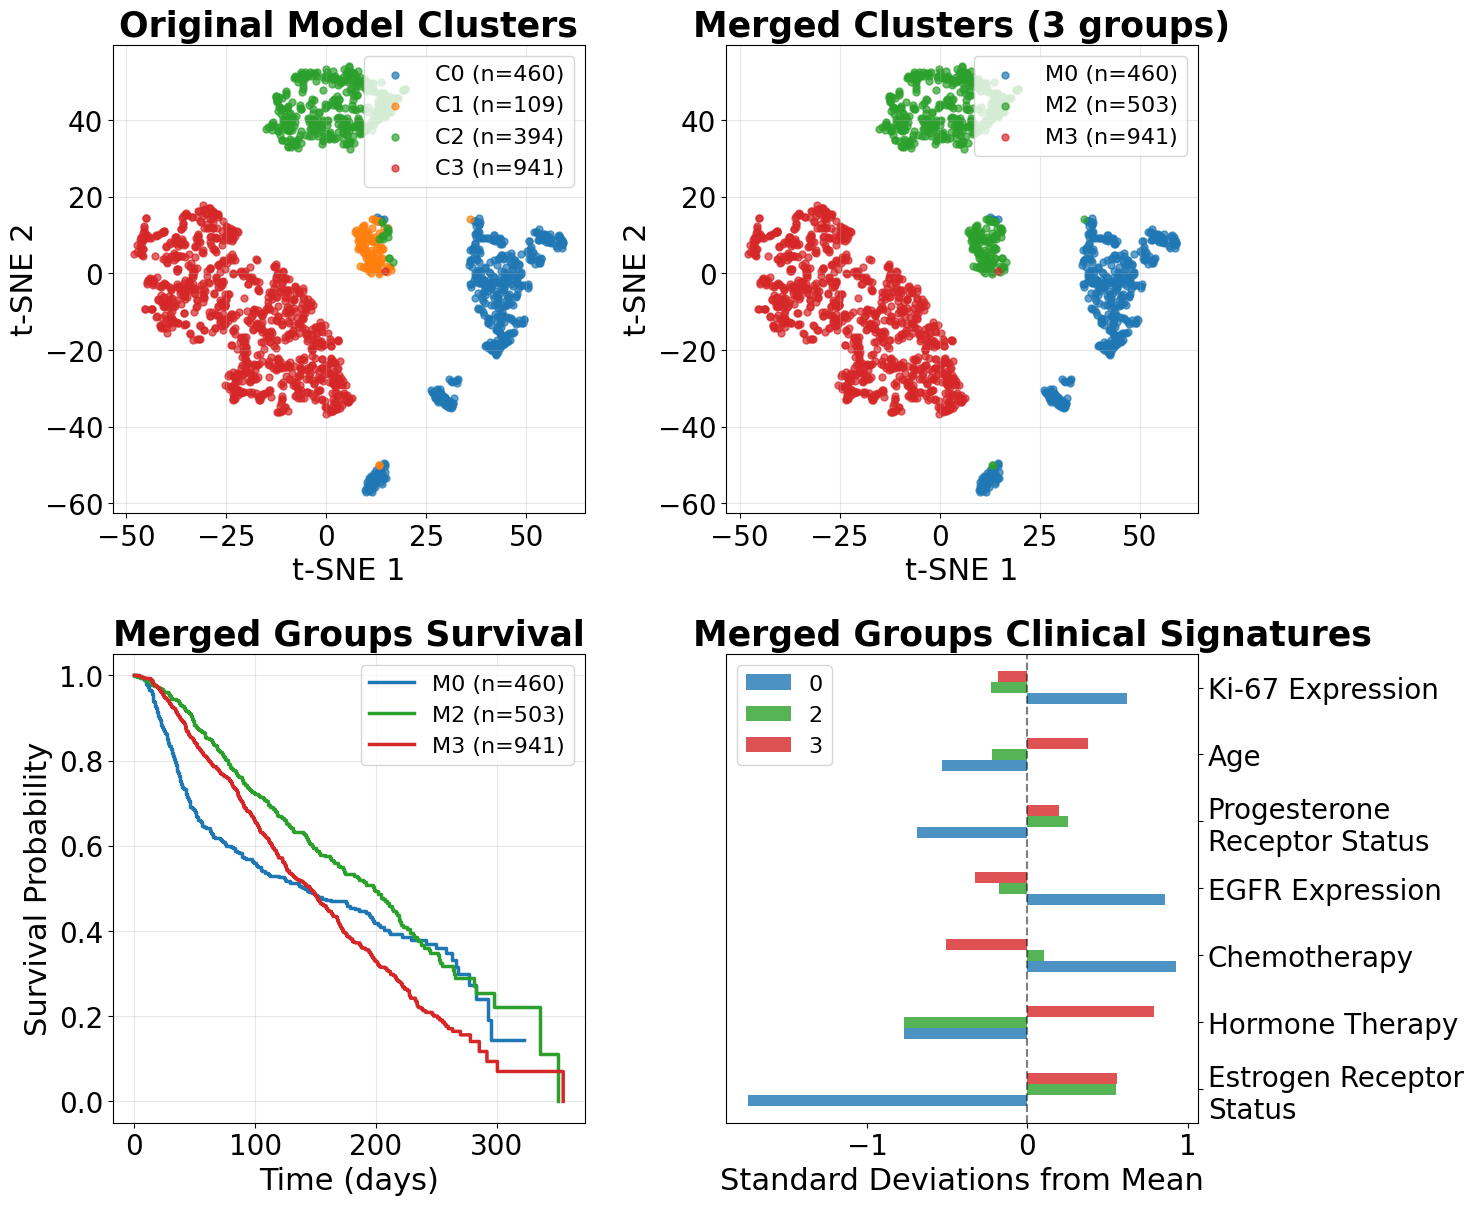

In [10]:
merge_clusters("metabric")

### PBC

[INFO] Merge mapping: {0: 0, 1: 1}
[INFO] Merged clusters: [np.int64(0), np.int64(1)]
[INFO] Merged Clusters Log-Rank Test Results:
Test statistic: 104.0467
p-value: 0.000000
*** Highly significant (p < 0.001) ***


/tmp/ipykernel_102631/1976485285.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space for labels to overflow on the right


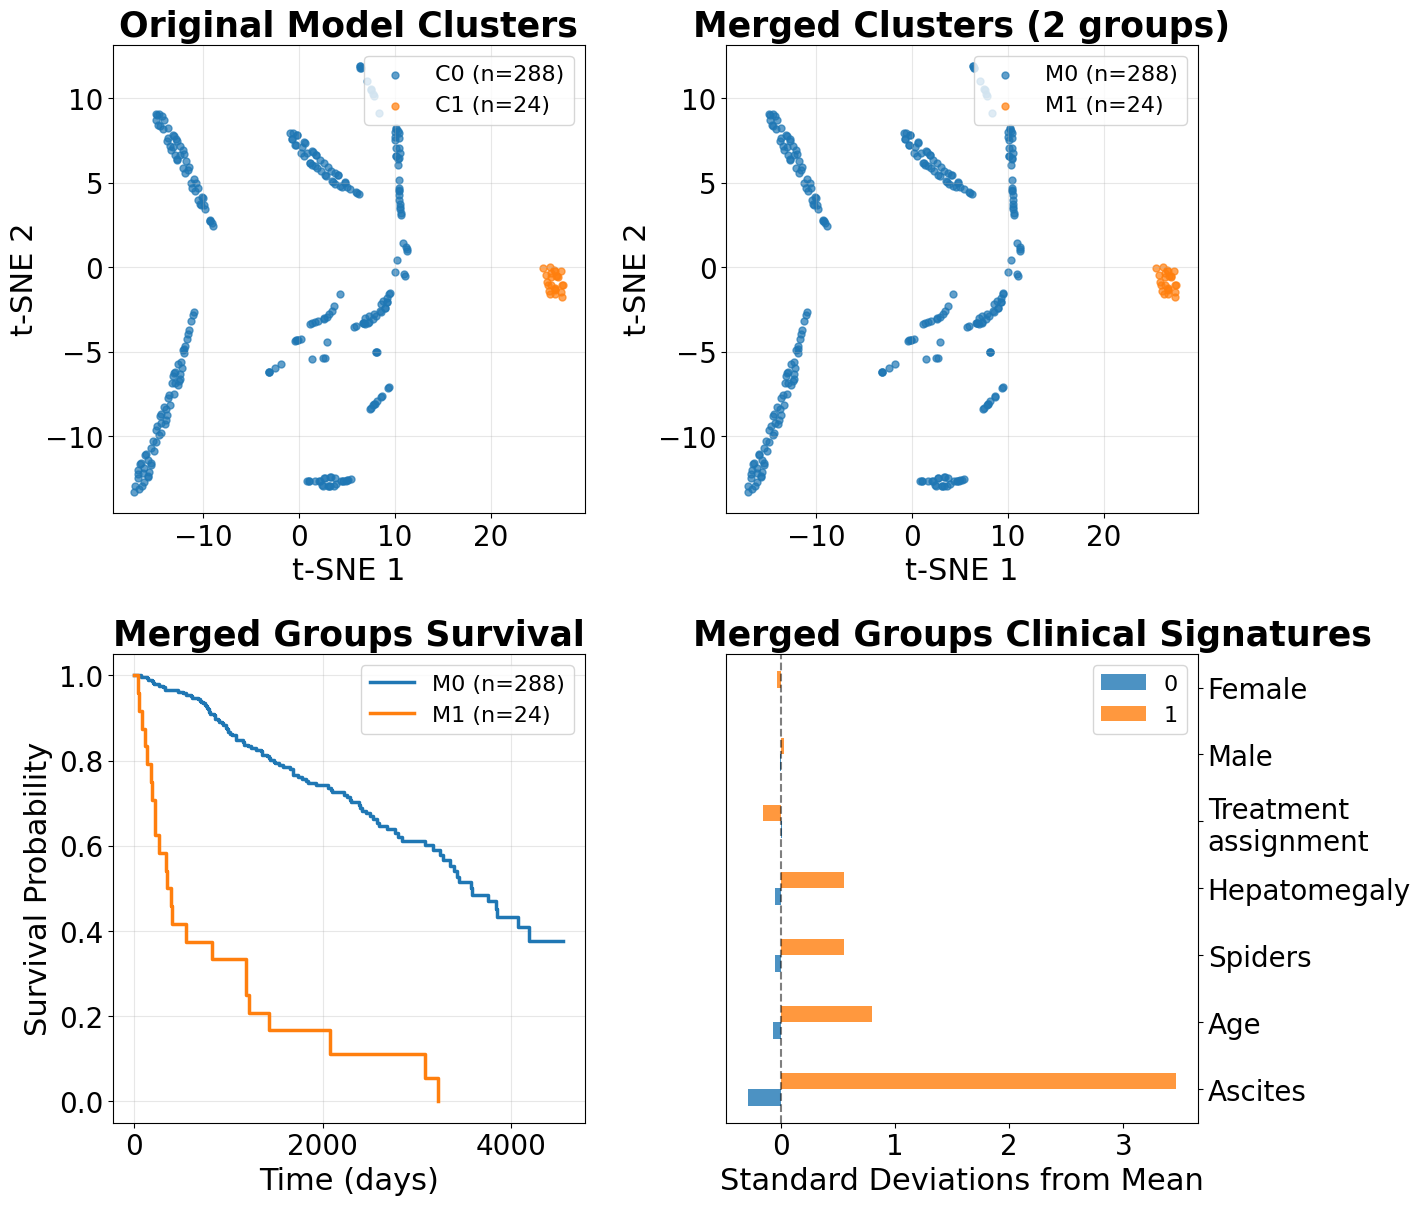

In [11]:
merge_clusters("pbc")

### TCGA-BRCA

[INFO] Merge mapping: {0: 0, 1: 0, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0, 7: 7}
[INFO] Merged clusters: [np.int64(0), np.int64(2), np.int64(7)]
[INFO] Merged Clusters Log-Rank Test Results:
Test statistic: 86.2042
p-value: 0.000000
*** Highly significant (p < 0.001) ***


/tmp/ipykernel_102631/1976485285.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space for labels to overflow on the right


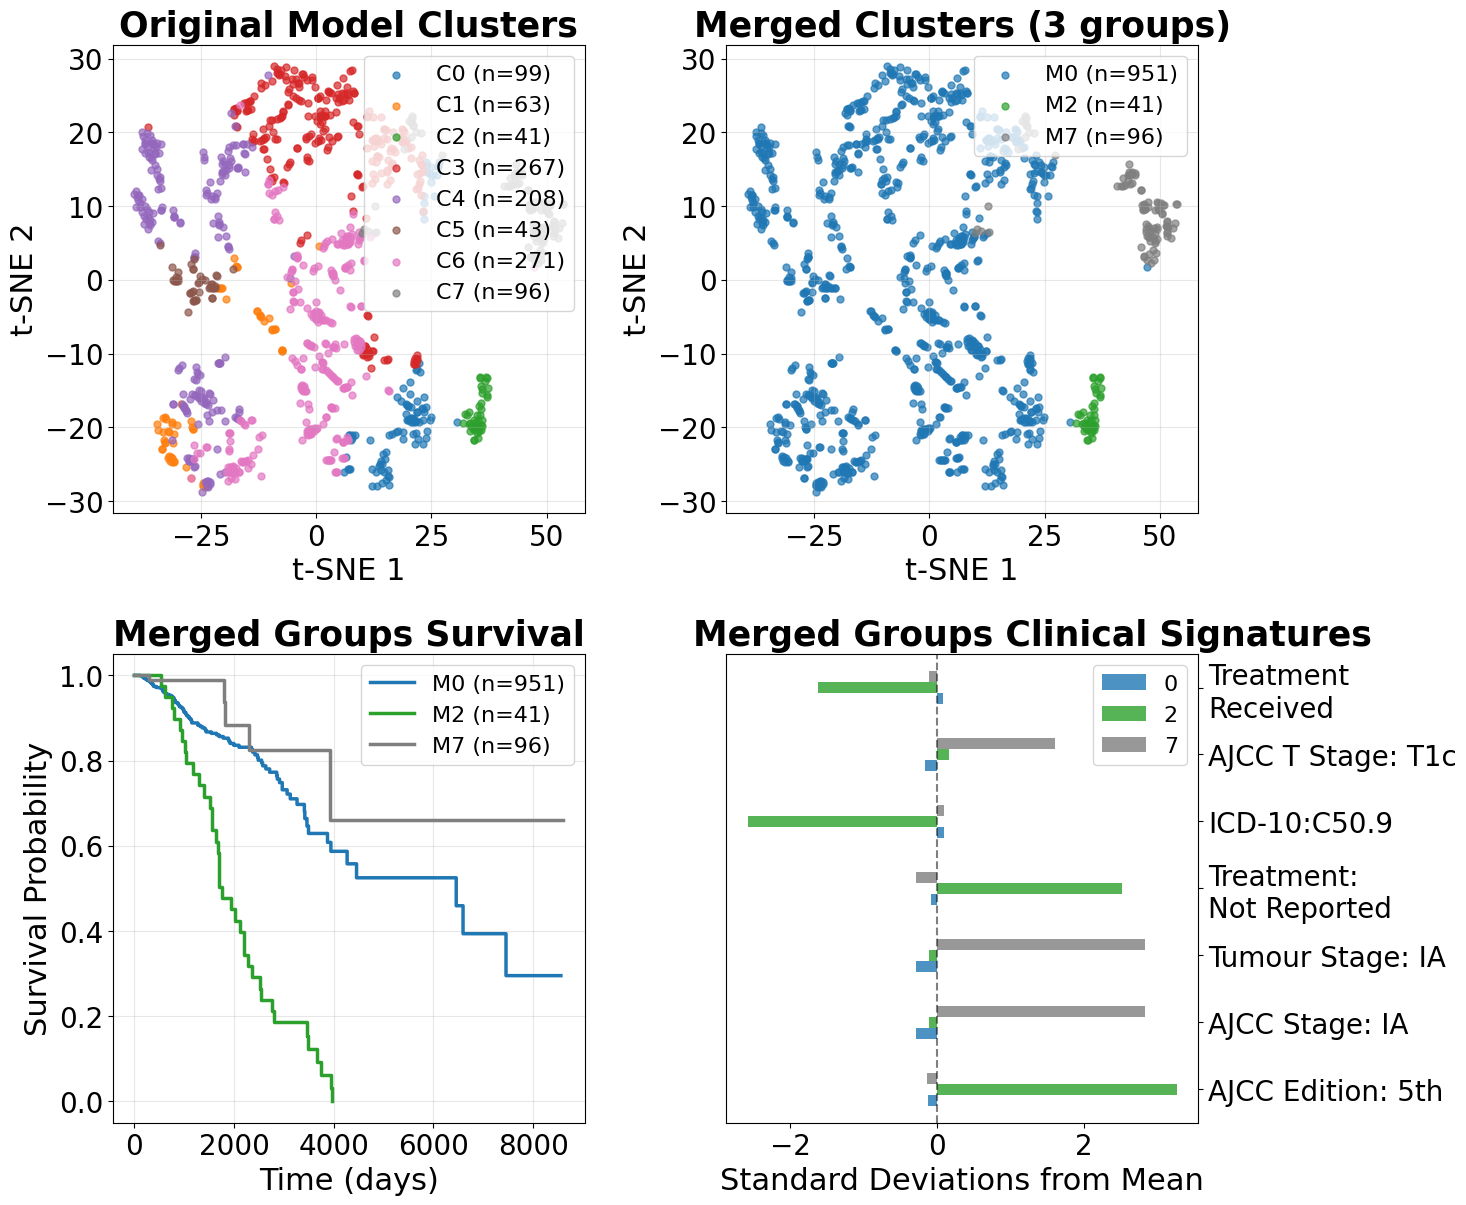

In [12]:
merge_clusters("tcga_brca")

### VETERANS

[INFO] Merge mapping: {0: 0, 1: 1, 2: 1, 3: 1, 4: 0, 5: 1}
[INFO] Merged clusters: [np.int64(0), np.int64(1)]
[INFO] Merged Clusters Log-Rank Test Results:
Test statistic: 9.4345
p-value: 0.002129
*** Significant (p < 0.05) ***


/tmp/ipykernel_102631/1976485285.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space for labels to overflow on the right


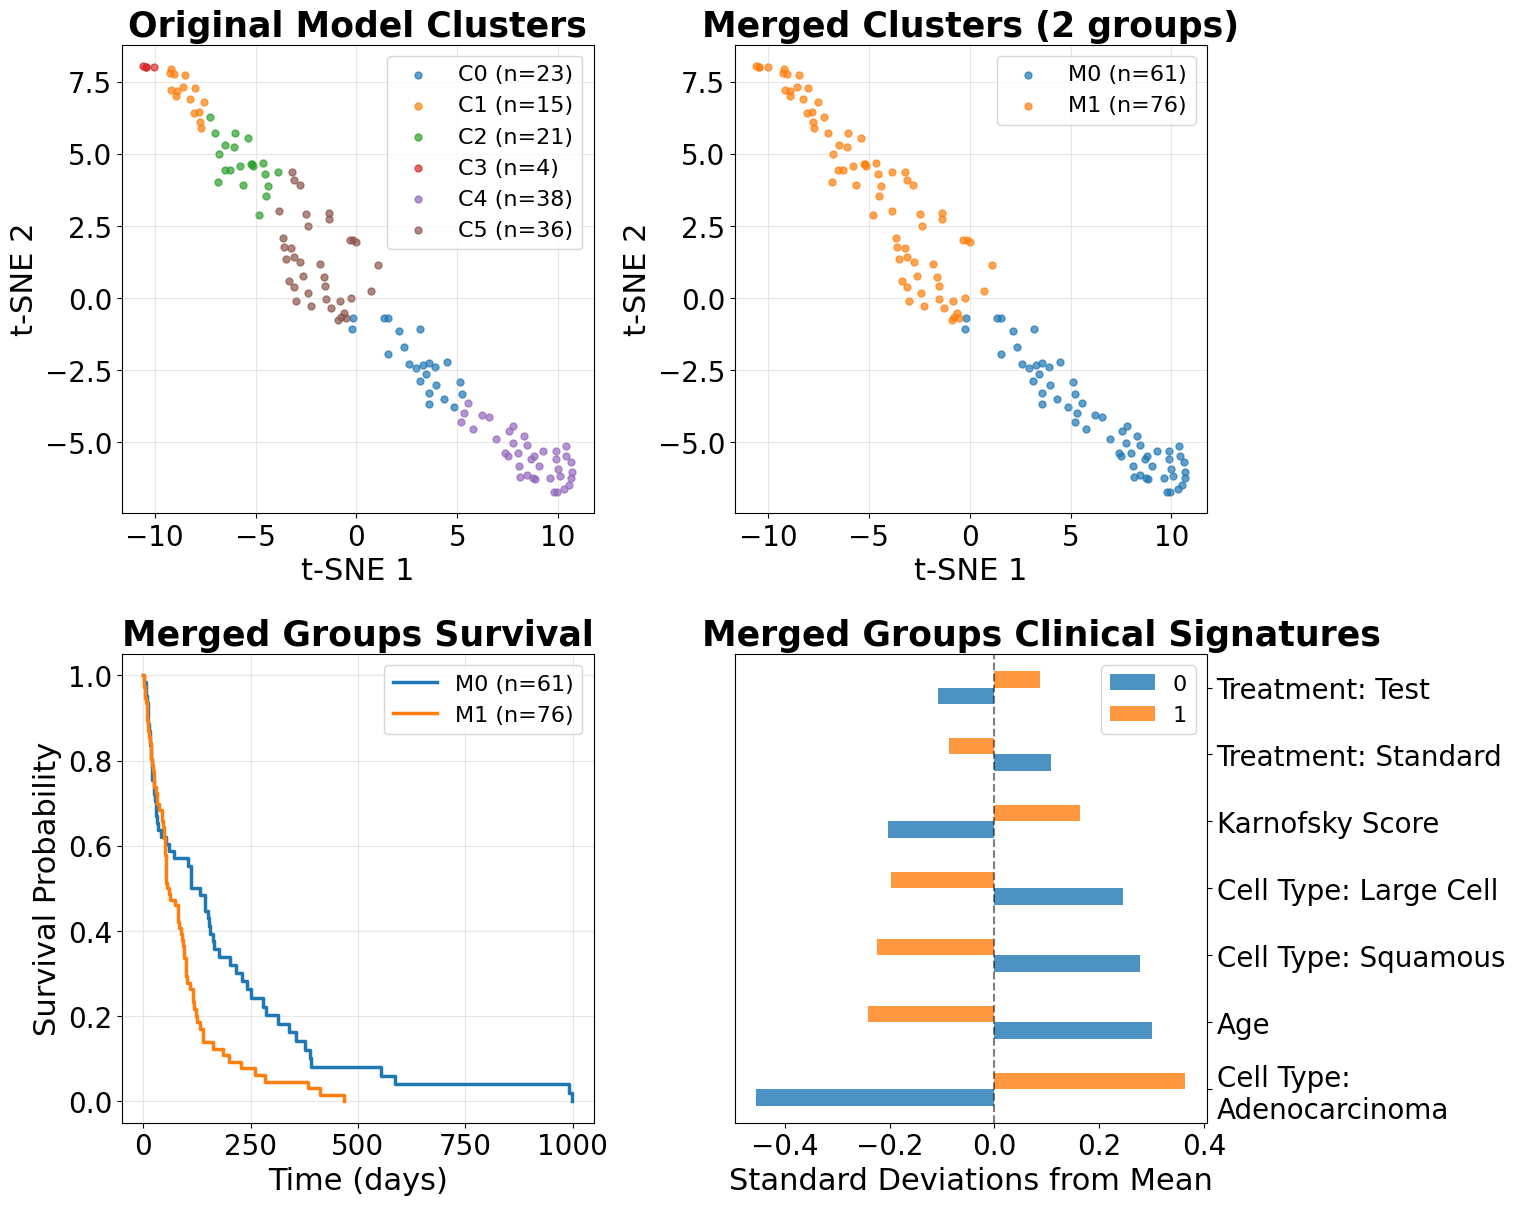

In [13]:
merge_clusters("veterans")

### WHAS

[INFO] Merge mapping: {0: 0, 1: 3, 2: 2, 3: 3, 4: 0}
[INFO] Merged clusters: [np.int64(0), np.int64(2), np.int64(3)]
[INFO] Merged Clusters Log-Rank Test Results:
Test statistic: 78.8394
p-value: 0.000000
*** Highly significant (p < 0.001) ***


/tmp/ipykernel_102631/1976485285.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space for labels to overflow on the right


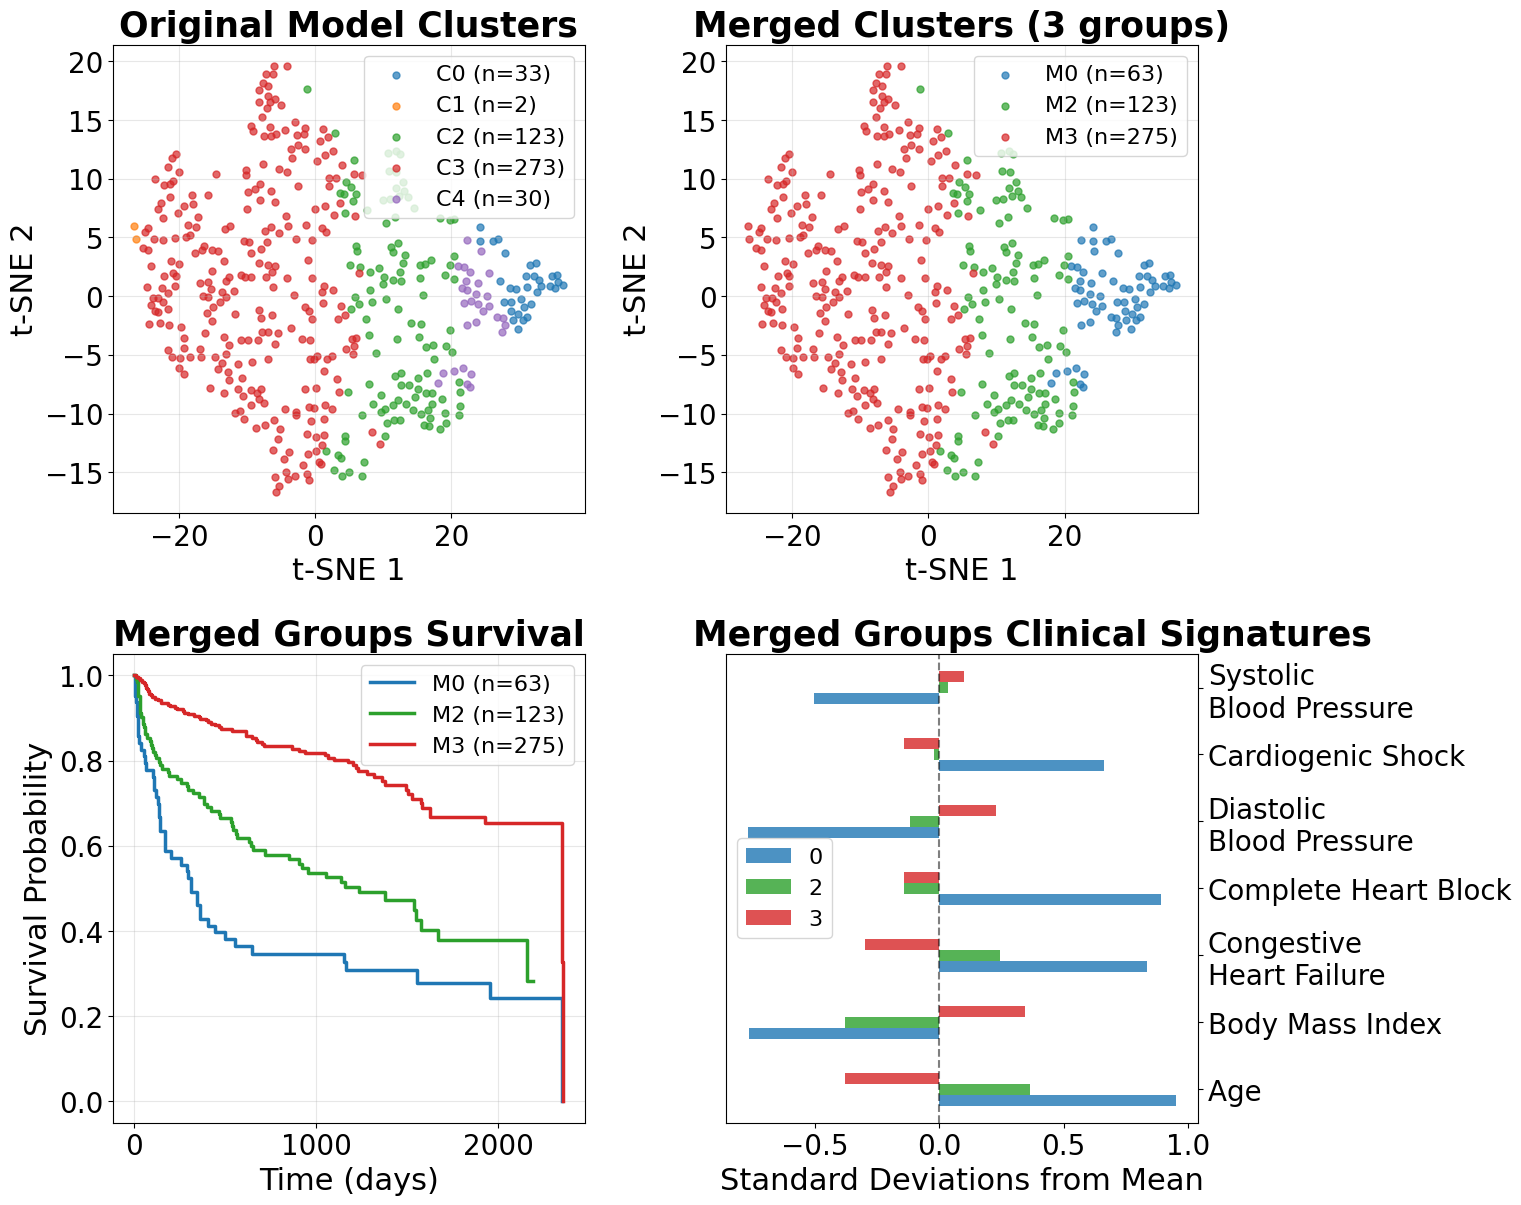

In [14]:
merge_clusters("whas")